# Deep Learning Coursework
## A. Data Preparation and Preprocessing

### 1. Data Loading

In [112]:
import torch
import os
import ast
import pickle
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, r2_score
import math

In [2]:
device = "mps" if torch.backends.mps.is_available() else "cpu"
root_dir = "2025_Dataset"
print(os.listdir(root_dir)[:5])

['P45_R5', 'P30_R5', 'P30_R30', 'P15_R45', '.DS_Store']


Loading folder from drive

In [3]:
pose_folders = []
for d in os.listdir(root_dir):
    path = os.path.join(root_dir, d)
    if os.path.isdir(path) and d.startswith("P") and "_R" in d:
        pose_folders.append(d)

pose_folders = sorted(pose_folders)
print(len(pose_folders))

40


Loading all pose folders into pose_folders.

In [4]:
def load_depth_mapping(folder_path):
    depth_files = []
    for f in os.listdir(folder_path):
        if f.endswith(".txt"):
            depth_files.append(f)
    
    if len(depth_files) != 1:
        raise ValueError(f"Expected 1 depth file in {folder_path}, found {depth_files}")
        
    depth_path = os.path.join(folder_path, depth_files[0])

    depth_map = {}
    with open(depth_path, "r") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            tup = ast.literal_eval(line)
            img_name = tup[0]
            depth_value = float(tup[1])
            depth_map[img_name] = depth_value

    return depth_map

Creating a function that creates a dictionary that maps depth with its corresponding image.

In [5]:
def parse_pose(folder_name):
    parts = folder_name.split("_")      
    p_str = parts[0]                    
    r_str = parts[1]                   

    pitch = int(p_str[1:])              
    roll = int(r_str[1:])              

    return pitch, roll


Function returning pitch and roll of a pose folder.

In [6]:
pose_list = []

for folder in pose_folders:
    pitch, roll = parse_pose(folder)  
    pose_list.append((pitch, roll))

unique_poses = []
for pose in pose_list:
    if pose not in unique_poses:
        unique_poses.append(pose)

unique_poses.sort()

print("Number of unique poses:", len(unique_poses))
print(unique_poses[:5])

pose_to_index = {}
for i, pose in enumerate(unique_poses):
    pose_to_index[pose] = i

print(list(pose_to_index.items())[:5])


Number of unique poses: 40
[(0, 0), (5, 0), (10, 0), (15, 0), (15, 5)]
[((0, 0), 0), ((5, 0), 1), ((10, 0), 2), ((15, 0), 3), ((15, 5), 4)]


Creating unique pose dictionary each corresponding to one index which will represent their class. 

In [7]:
samples = []

for folder in pose_folders:
    folder_path = os.path.join(root_dir, folder)

    pitch, roll = parse_pose(folder)
    pose_class = pose_to_index[(pitch, roll)]

    depth_map = load_depth_mapping(folder_path)

    image_files = []
    for name in os.listdir(folder_path):
        if name.lower().endswith(".jpg"):
            full_path = os.path.join(folder_path, name)
            image_files.append(full_path)
    image_files.sort()

    for img_path in image_files:
        img_name = os.path.basename(img_path)

        if img_name not in depth_map:
            continue

        depth_value = depth_map[img_name]

        sample = {
            "image_path": img_path,
            "pitch": pitch,
            "roll": roll,
            "pose_class": pose_class,
            "depth": depth_value,
        }

        samples.append(sample)

print("Total number of samples:", len(samples))
print("One sample looks like:", samples[0])

Total number of samples: 2000
One sample looks like: {'image_path': '2025_Dataset/P0_R0/video_14_stable_bot_l6s3_P0_R0_00000.jpg', 'pitch': 0, 'roll': 0, 'pose_class': 0, 'depth': 0.415}


Analyzes all pose folders to build a list that holds all the images with its corresponding pitch, roll, class of the pose, and value of depth.

In [8]:
basic_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

Defining a basic transformation for all images to have the same size and convert to normalised tensors.

In [9]:
class MicrorobotDataset(Dataset):
    def __init__(self, samples, transform=None, target_type="both"):

        self.samples = samples
        self.transform = transform
        self.target_type = target_type

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        s = self.samples[idx]

        img_path = s["image_path"]
        image = Image.open(img_path).convert("RGB")
        if self.transform is not None:
            image = self.transform(image)
    
        pose_class = s["pose_class"]
        depth = s["depth"]

        if self.target_type == "pose":
            return image, pose_class
        elif self.target_type == "depth":
            return image, depth
        else:
            return image, pose_class, depth

full_dataset = MicrorobotDataset(samples, transform=basic_transform, target_type="both")
print("Dataset size:", len(full_dataset))

img, pose_cls, depth = full_dataset[0]
print(img.shape)
print(pose_cls)
print(depth)


Dataset size: 2000
torch.Size([3, 256, 256])
0
0.415


A dataset is created that reads each image from the samples and applies the basic transformation and then returns the corresponding pose class, and depth as well as image tensor.

### 2. Exploratory Data Analysis

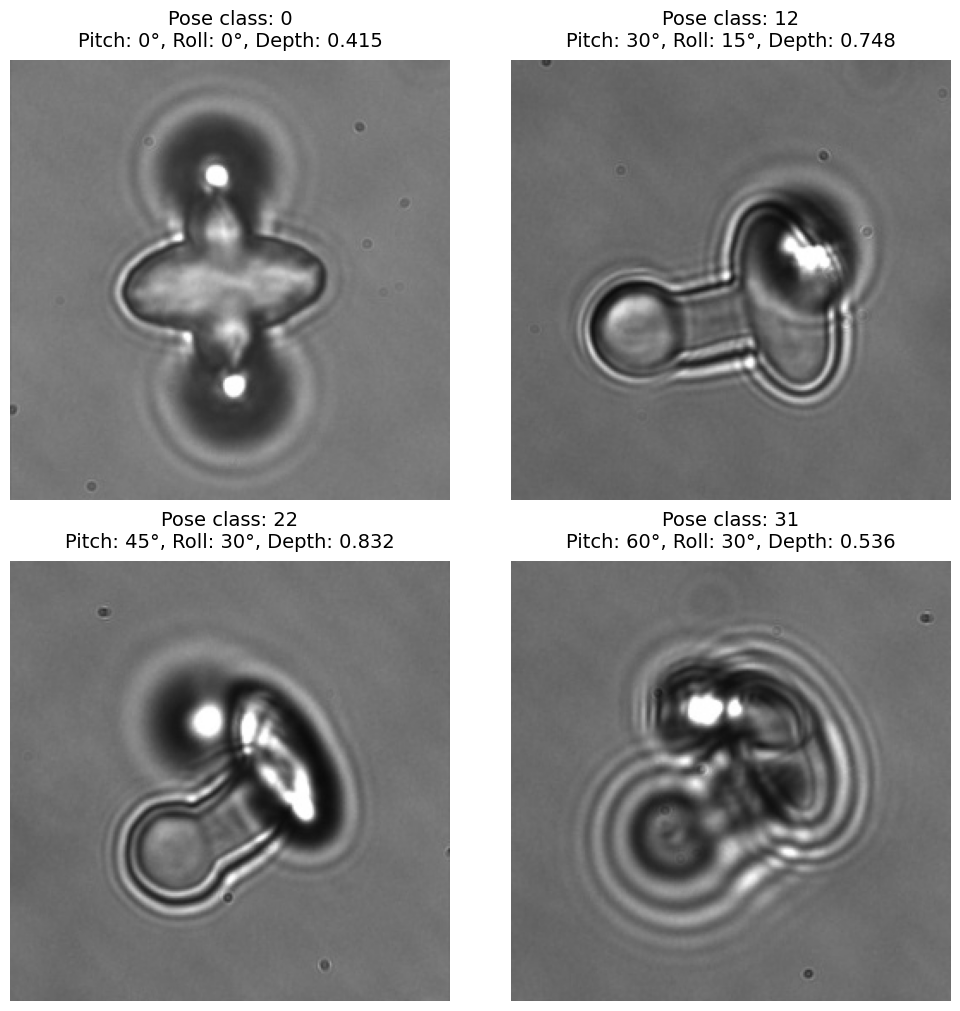

In [151]:
indices_to_show = [0, 500, 1000, 1500]

fig, axes = plt.subplots(2, 2, figsize=(10, 10), constrained_layout=True)

for ax, idx in zip(axes.flat, indices_to_show):
    img, pose_cls, depth = full_dataset[idx]
    sample = samples[idx]

    ax.imshow(img.permute(1, 2, 0))
    ax.axis("off")

    title = (
        f"Pose class: {pose_cls}\n"
        f"Pitch: {sample['pitch']}°, Roll: {sample['roll']}°, Depth: {depth:.3f}"
    )
    ax.set_title(title, fontsize=14, pad=10) 

plt.show()


The figure above shows four different examples of microrobot images each with a different pose class. Through this not only can we confirm our dataset is working but also that each class depicts indeed a different pose seen in the image.

In [11]:
pose_counts = {}

for s in samples:
    c = s["pose_class"]
    if c not in pose_counts:
        pose_counts[c] = 0
    pose_counts[c] += 1

num_classes = len(pose_counts)
print("Number classes:", num_classes)
print("Samples per class (first 10 classes):")

for cls in sorted(pose_counts.keys())[:10]:
    print(f"{cls}: {pose_counts[cls]} samples")
    
depth_values = []

for s in samples:
    depth_values.append(s["depth"])

depth_min = min(depth_values)
depth_max = max(depth_values)
depth_mean = sum(depth_values) / len(depth_values)
print("Depth min:", depth_min)
print("Depth max:", depth_max)
print("Depth mean:", depth_mean)

Number classes: 40
Samples per class (first 10 classes):
0: 50 samples
1: 50 samples
2: 50 samples
3: 50 samples
4: 50 samples
5: 50 samples
6: 50 samples
7: 50 samples
8: 50 samples
9: 50 samples
Depth min: 0.0
Depth max: 1.0
Depth mean: 0.443198


From the results above, 40 distinct pose clsses are identified and it seems like there are exactly 50 images for each class displaying a perfectly class balanced dataset. From the depth values a range of [0,1] can be observed with a mean of 0.44. This can be visualized further by plotting histograms.

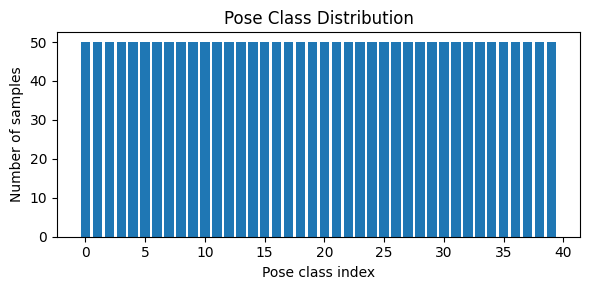

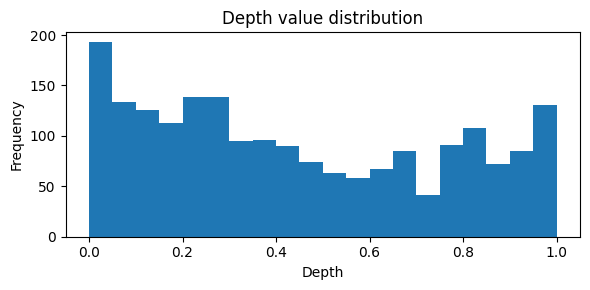

In [12]:
classes = sorted(pose_counts.keys())
counts = [pose_counts[c] for c in classes]

plt.figure(figsize=(6, 3))
plt.bar(classes, counts)
plt.xlabel("Pose class index")
plt.ylabel("Number of samples")
plt.title("Pose Class Distribution")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 3))
plt.hist(depth_values, bins=20)
plt.xlabel("Depth")
plt.ylabel("Frequency")
plt.title("Depth value distribution")
plt.tight_layout()
plt.show()

As seen from the histograms, the pose class distribution confirms that it is perfectly balanced, with each pose class having 50 samples. On the other hand. the deapth histogram is less even, with different number of sampples across all values in its range. Theres seem to be a higher concentration for a lower depth value and also appoaching high depth value of 1 but a smaller concentration in the upper middel value range roughly from 0.6 to 0.8. Although having an uneven distribution, no severe skewness is observable.

### 3-5. Data Splitting, Augmentation and Normalization

In [13]:
all_index = list(range(len(samples)))
all_labels = [s["pose_class"] for s in samples]

train_idx, temp_idx = train_test_split(all_index, test_size=0.4, stratify=all_labels, random_state=42)

temp_labels = [all_labels[i] for i in temp_idx]

val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, stratify=temp_labels, random_state=42)

print("Train size:", len(train_idx))
print("Val size:", len(val_idx))
print("Test size:", len(test_idx))

Train size: 1200
Val size: 400
Test size: 400


Next we decided to split the data into training, validation and test set before augmentaton and normalization as to prevent data leakage (scikit-learn developers, 2025). First we split the indices and use stratified splits to maintain class balance.

In [14]:
def select_samples(samples, indices):
    return [samples[i] for i in indices]

train_samples = select_samples(samples, train_idx)
val_samples   = select_samples(samples, val_idx)
test_samples  = select_samples(samples, test_idx)

print("Train samples:", len(train_samples))
print("Val samples:", len(val_samples))
print("Test samples:", len(test_samples))

Train samples: 1200
Val samples: 400
Test samples: 400


Using indices we split the samples. 

In [15]:
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),        
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),                  
])

val_test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

A very weak augmentation is applied to the samples in the training set of around 0.1 in brightness and contrast to simulate small changes in lighting when an image is captured rendering the model more robust. The weak augmentation is used to not distort pose or depth perception too much that it would contribute negatively to training the model. Validation and test images are not augmented to reflect performance on realistic inputs.

In [16]:
train_depths = [s["depth"] for s in train_samples]
depth_mean = sum(train_depths) / len(train_depths)

squared_diffs = [(d - depth_mean) ** 2 for d in train_depths]
depth_var = sum(squared_diffs) / len(squared_diffs)
depth_std = depth_var ** 0.5

class MicrorobotDataset(Dataset):
    def __init__(self, samples, transform=None, target_type="both", depth_mean=None, depth_std=None, standardize_depth=False):

        self.samples = samples
        self.transform = transform
        self.target_type = target_type
        self.standardize_depth = standardize_depth
        self.depth_mean = depth_mean
        self.depth_std = depth_std

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        s = self.samples[idx]

        img_path = s["image_path"]
        image = Image.open(img_path).convert("RGB")
        if self.transform is not None:
            image = self.transform(image)
    
        pose_class = s["pose_class"]
        depth = s["depth"]

        if self.standardize_depth:
            depth = (depth - self.depth_mean) / self.depth_std

        if self.target_type == "pose":
            return image, pose_class
        elif self.target_type == "depth":
            return image, depth
        else:
            return image, pose_class, depth

The MicrorobotDataset class is redefined to standardise the depth values by using the mean and standard deviation computed with the training set that are then applied also to validation and test set.

In [17]:
train_dataset = MicrorobotDataset(
    train_samples,
    transform=train_transform,
    target_type="both",
    depth_mean=depth_mean,
    depth_std=depth_std,
    standardize_depth=True,
)

val_dataset = MicrorobotDataset(
    val_samples,
    transform=val_test_transform,
    target_type="both",
    depth_mean=depth_mean,
    depth_std=depth_std,
    standardize_depth=True,
)

test_dataset = MicrorobotDataset(
    test_samples,
    transform=val_test_transform,
    target_type="both",
    depth_mean=depth_mean,
    depth_std=depth_std,
    standardize_depth=True,
)

The training, validation and test datasets are created with their respective splits, using respective transoformations, with augmentation being applied only to train set, and all sets' depth value are standardised using training set mean and standard deviation.

In [18]:
batch_size = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,      
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,     
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
)

Data loaders are created to use in training, validation and test sets in order to iterate over the dataset in batches of 32 samples each batch.

## B. Pose Estimation (Classification)

### 1-4. Model Design, Optimization, Regulation, Evaluation and Analysis

In [19]:
num_pose_classes = 40

class PoseCNN_V1(nn.Module):
    def __init__(self, num_classes=num_pose_classes):
        super().__init__()

        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.conv_block3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.fc = nn.Linear(64 * 32 * 32, num_classes)

    def forward(self, x):
        x = self.conv_block1(x)  
        x = self.conv_block2(x)  
        x = self.conv_block3(x)   

        x = x.view(x.size(0), -1) 
        x = self.fc(x)            
        return x

pose_model_v1 = PoseCNN_V1(num_pose_classes).to(device)
print(pose_model_v1)


PoseCNN_V1(
  (conv_block1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=65536, out_features=40, bias=True)
)


We define a three block CNN using a ReLU after convolution and then max pooling producing a 64 x 32 x 32 feature map. This is then followed by a fully connected layer that outputs 40 logits, one for each pose class.

In [20]:
pose_loss = nn.CrossEntropyLoss()
pose_optimizer = optim.Adam(pose_model_v1.parameters(), lr=1e-3)
def compute_accuracy(logits, labels):
    preds = torch.argmax(logits, dim=1)        
    correct = (preds == labels).sum().item()   
    total = labels.size(0)
    return correct / total

A standard approach is used with cross entropy loss and Adam as the optimiser, with a function to help compute the accuracy of the model by summing correct observations predicted over total observations.

In [21]:
def train_one_epoch(model, loader, optimizer, loss_fn, device):
    model.train() 

    running_loss = 0.0
    running_correct = 0
    running_total = 0

    for images, pose_labels, depths in loader:
        images = images.to(device)
        pose_labels = pose_labels.to(device)

        optimizer.zero_grad()              
        logits = model(images)            
        loss = loss_fn(logits, pose_labels)

        loss.backward()                   
        optimizer.step()                  

        batch_size = pose_labels.size(0)
        running_loss += loss.item() * batch_size

        preds = torch.argmax(logits, dim=1)
        running_correct += (preds == pose_labels).sum().item()
        running_total += batch_size

    epoch_loss = running_loss / running_total
    epoch_acc = running_correct / running_total
    return epoch_loss, epoch_acc


def evaluate(model, loader, loss_fn, device):
    model.eval()   
    running_loss = 0.0
    running_correct = 0
    running_total = 0

    with torch.no_grad(): 
        for images, pose_labels, depths in loader:
            images = images.to(device)
            pose_labels = pose_labels.to(device)

            logits = model(images)
            loss = loss_fn(logits, pose_labels)

            batch_size = pose_labels.size(0)
            running_loss += loss.item() * batch_size

            preds = torch.argmax(logits, dim=1)
            running_correct += (preds == pose_labels).sum().item()
            running_total += batch_size

    epoch_loss = running_loss / running_total
    epoch_acc = running_correct / running_total
    return epoch_loss, epoch_acc


Two functions are defined to use for training the model for one epoch and evaluating it, returning loss and accuracy of the epoch. 

In [22]:
num_epochs = 5

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(
        pose_model_v1,
        train_loader,
        pose_optimizer,
        pose_loss,
        device,
    )

    val_loss, val_acc = evaluate(
        pose_model_v1,
        val_loader,
        pose_loss,
        device,
    )

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(
        f"CNN Version 1 Epoch {epoch+1}: Train loss: {train_loss:.3f}, Train acc: {train_acc:.3f}, Val loss: {val_loss:.3f}, Val acc: {val_acc:.3f}" 
    )

CNN Version 1 Epoch 1: Train loss: 3.624, Train acc: 0.092, Val loss: 3.007, Val acc: 0.450
CNN Version 1 Epoch 2: Train loss: 1.647, Train acc: 0.568, Val loss: 0.971, Val acc: 0.690
CNN Version 1 Epoch 3: Train loss: 0.703, Train acc: 0.752, Val loss: 0.743, Val acc: 0.777
CNN Version 1 Epoch 4: Train loss: 0.432, Train acc: 0.845, Val loss: 0.716, Val acc: 0.812
CNN Version 1 Epoch 5: Train loss: 0.314, Train acc: 0.907, Val loss: 0.542, Val acc: 0.855


We initially visualize if the model is training properly using just 5 epochs checking if loss decreases and accuracy increases, we will increase the number of epochs later on for the actual training.

In [54]:
class PoseCNN_V2(nn.Module):
    def __init__(self, num_classes=num_pose_classes):
        super().__init__()

        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.conv_block3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.fc1 = nn.Linear(64 * 32 * 32, 256)
        self.dropout = nn.Dropout(p=0.2)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)

        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))      
        x = self.dropout(x)          
        x = self.fc2(x)           
        return x

pose_model_v2 = PoseCNN_V2(num_pose_classes).to(device)
print(pose_model_v2)

PoseCNN_V2(
  (conv_block1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=65536, out_features=256, bias=True)
  (dropout): Dropout(p=0.2, inplac

For the second CNN architecture, we decided to keep the same Convolution, ReLU and max pool structure however, we also add batch normalisation to each block and two fully connected layers instead of one, producing 256 units in the first hidden layer with ReLU and dropout before using the final layer to output 40 logits.

In [55]:
pose_loss_v2 = nn.CrossEntropyLoss()
pose_optimizer_v2 = optim.Adam(pose_model_v2.parameters(), lr=1e-3)

num_epochs_v2 = 5

train_losses_v2 = []
val_losses_v2 = []
train_accuracies_v2 = []
val_accuracies_v2 = []

for epoch in range(num_epochs_v2):
    train_loss, train_acc = train_one_epoch(
        pose_model_v2,
        train_loader,
        pose_optimizer_v2,
        pose_loss_v2,
        device,
    )

    val_loss, val_acc = evaluate(
        pose_model_v2,
        val_loader,
        pose_loss_v2,
        device,
    )

    train_losses_v2.append(train_loss)
    val_losses_v2.append(val_loss)
    train_accuracies_v2.append(train_acc)
    val_accuracies_v2.append(val_acc)

    print(
        f"CNN Version 2 Epoch {epoch+1}: Train loss: {train_loss:.3f}, Train acc: {train_acc:.3f}, Val loss: {val_loss:.3f}, Val acc: {val_acc:.3f}"
    )

CNN Version 2 Epoch 1: Train loss: 6.168, Train acc: 0.143, Val loss: 2.600, Val acc: 0.378
CNN Version 2 Epoch 2: Train loss: 1.849, Train acc: 0.458, Val loss: 1.133, Val acc: 0.637
CNN Version 2 Epoch 3: Train loss: 1.271, Train acc: 0.608, Val loss: 0.862, Val acc: 0.720
CNN Version 2 Epoch 4: Train loss: 0.864, Train acc: 0.714, Val loss: 0.706, Val acc: 0.780
CNN Version 2 Epoch 5: Train loss: 0.755, Train acc: 0.752, Val loss: 0.598, Val acc: 0.800


Same as before we visualize how the model trains and evaluates with 5 epochs, its worth noting that the second version seems to have a much slower learning rate in terms of accuracy increasing and loss decreasing suggesting the batch normalisation and added hidden layer require more training epochs. The regularisation of dropout and batch norm's effects can also be seen by how in the first 5 epochs the accuracy and loss for Validation set perform better than the training set. 

In [25]:
class PoseResNet18(nn.Module):
    def __init__(self, num_classes=40):
        super().__init__()

        self.backbone = models.resnet18(weights=None)
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.backbone(x)

pose_model_v3 = PoseResNet18(num_classes=num_pose_classes).to(device)
print(pose_model_v3.backbone.fc)


Linear(in_features=512, out_features=40, bias=True)


In the third version of CNN we decide to use a standard ResNet18 architecture from torchvision, with the finaly fully connected layer replaced for 40 classes output. 

In [26]:
pose_loss_v3 = nn.CrossEntropyLoss()
pose_optimizer_v3 = optim.Adam(pose_model_v3.parameters(), lr=1e-3)

num_epochs_v3 = 5

train_losses_v3 = []
val_losses_v3 = []
train_accuracies_v3 = []
val_accuracies_v3 = []

for epoch in range(num_epochs_v3):
    train_loss, train_acc = train_one_epoch(
        pose_model_v3,
        train_loader,
        pose_optimizer_v3,
        pose_loss_v3,
        device,
    )

    val_loss, val_acc = evaluate(
        pose_model_v3,
        val_loader,
        pose_loss_v3,
        device,
    )

    train_losses_v3.append(train_loss)
    val_losses_v3.append(val_loss)
    train_accuracies_v3.append(train_acc)
    val_accuracies_v3.append(val_acc)

    print(
        f"CNN Version 3 Epoch {epoch+1}: Train loss: {train_loss:.3f}, Train acc: {train_acc:.3f}, Val loss: {val_loss:.3f}, Val acc: {val_acc:.3f}"
    )

CNN Version 3 Epoch 1: Train loss: 2.869, Train acc: 0.196, Val loss: 5.309, Val acc: 0.030
CNN Version 3 Epoch 2: Train loss: 1.519, Train acc: 0.532, Val loss: 1.678, Val acc: 0.393
CNN Version 3 Epoch 3: Train loss: 1.004, Train acc: 0.677, Val loss: 2.798, Val acc: 0.278
CNN Version 3 Epoch 4: Train loss: 0.783, Train acc: 0.748, Val loss: 1.355, Val acc: 0.520
CNN Version 3 Epoch 5: Train loss: 0.585, Train acc: 0.805, Val loss: 1.146, Val acc: 0.598


Visualising 5 epochs for our CNN version 3 or ResNet18 we can see that the model is working correctly with accuracy increasing and loss decreasing at a steady rate, faster than our CNN version 2 but slower than our CNN version 1, indicating the simpler model might be able to converge faster as the dataset is relatively not large. 

In [28]:
extra_epochs = 10

for epoch in range(5, 5 + extra_epochs):
    train_loss, train_acc = train_one_epoch(
        pose_model_v1,
        train_loader,
        pose_optimizer,
        pose_loss,
        device,
    )

    val_loss, val_acc = evaluate(
        pose_model_v1,
        val_loader,
        pose_loss,
        device,
    )

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(
        f"CNN Version 1 Epoch {epoch+1}: Train loss: {train_loss:.3f}, Train acc: {train_acc:.3f}, Val loss: {val_loss:.3f}, Val acc: {val_acc:.3f}"
    )

CNN Version 1 Epoch 6: Train loss: 0.222, Train acc: 0.922, Val loss: 0.543, Val acc: 0.875
CNN Version 1 Epoch 7: Train loss: 0.151, Train acc: 0.953, Val loss: 0.480, Val acc: 0.887
CNN Version 1 Epoch 8: Train loss: 0.110, Train acc: 0.969, Val loss: 0.532, Val acc: 0.885
CNN Version 1 Epoch 9: Train loss: 0.119, Train acc: 0.956, Val loss: 0.610, Val acc: 0.838
CNN Version 1 Epoch 10: Train loss: 0.116, Train acc: 0.958, Val loss: 0.578, Val acc: 0.882
CNN Version 1 Epoch 11: Train loss: 0.061, Train acc: 0.978, Val loss: 0.607, Val acc: 0.890
CNN Version 1 Epoch 12: Train loss: 0.064, Train acc: 0.977, Val loss: 0.517, Val acc: 0.897
CNN Version 1 Epoch 13: Train loss: 0.034, Train acc: 0.993, Val loss: 0.521, Val acc: 0.910
CNN Version 1 Epoch 14: Train loss: 0.030, Train acc: 0.990, Val loss: 0.535, Val acc: 0.897
CNN Version 1 Epoch 15: Train loss: 0.019, Train acc: 0.995, Val loss: 0.587, Val acc: 0.905


Since we already trained 5 epochs for each model we keep training another 10 epochs for CNN version 1 having in total 15 epochs. Observing the validation set, 15 epochs were enough to allow the accuracy to converge which the model does around 89-91%.

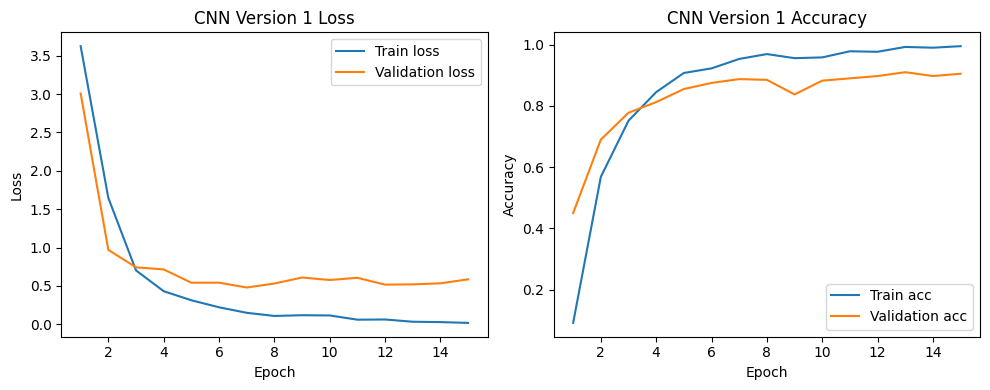

In [67]:
epochs_v1 = range(1, len(train_losses) + 1)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_v1, train_losses, label="Train loss")
plt.plot(epochs_v1, val_losses, label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("CNN Version 1 Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_v1, train_accuracies, label="Train acc")
plt.plot(epochs_v1, val_accuracies, label="Validation acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("CNN Version 1 Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

To visualize the convergence better we plot loss and accuracy of train and validation set over epochs. We can clearly visualise the model converging as well as a slight overfitting from validation as it stays around the same value for both loss and accuracy while training keeps getting better in both senses, lower loss, and higher accuracy.

In [56]:
extra_epochs_v2 = 10

for epoch in range(5, 5 + extra_epochs_v2):
    train_loss, train_acc = train_one_epoch(
        pose_model_v2,
        train_loader,
        pose_optimizer_v2,
        pose_loss_v2,
        device,
    )

    val_loss, val_acc = evaluate(
        pose_model_v2,
        val_loader,
        pose_loss_v2,
        device,
    )

    train_losses_v2.append(train_loss)
    val_losses_v2.append(val_loss)
    train_accuracies_v2.append(train_acc)
    val_accuracies_v2.append(val_acc)

    print(
        f"CNN Version 2 Epoch {epoch+1}: Train loss: {train_loss:.3f}, Train acc: {train_acc:.3f}, Val loss: {val_loss:.3f}, Val acc: {val_acc:.3f}"
    )


CNN Version 2 Epoch 6: Train loss: 0.599, Train acc: 0.802, Val loss: 0.735, Val acc: 0.775
CNN Version 2 Epoch 7: Train loss: 0.427, Train acc: 0.850, Val loss: 0.368, Val acc: 0.885
CNN Version 2 Epoch 8: Train loss: 0.342, Train acc: 0.880, Val loss: 0.467, Val acc: 0.860
CNN Version 2 Epoch 9: Train loss: 0.292, Train acc: 0.896, Val loss: 0.404, Val acc: 0.890
CNN Version 2 Epoch 10: Train loss: 0.250, Train acc: 0.924, Val loss: 0.365, Val acc: 0.902
CNN Version 2 Epoch 11: Train loss: 0.240, Train acc: 0.917, Val loss: 0.627, Val acc: 0.792
CNN Version 2 Epoch 12: Train loss: 0.192, Train acc: 0.932, Val loss: 0.378, Val acc: 0.912
CNN Version 2 Epoch 13: Train loss: 0.150, Train acc: 0.941, Val loss: 0.376, Val acc: 0.910
CNN Version 2 Epoch 14: Train loss: 0.167, Train acc: 0.942, Val loss: 0.279, Val acc: 0.922
CNN Version 2 Epoch 15: Train loss: 0.175, Train acc: 0.942, Val loss: 0.424, Val acc: 0.905


For CNN version 2 we added 10 extra epochs to the initial 5, like in version 1, for a total of 15 epochs. The validation accuracy towards the end fuctuates around 90-92% with a peak in epoch 14 at 92.2%, suggesting the model has converged. In order to optimise and regularise the model, we also checked in earlier tests, if adding more epochs led to better performance, and although it did increase training accuracy, it led to a steep decrease in validation accuracy suggesting overfitting, therefore choosing to stop at 15 epochs. We also changed the dropout from 0.5 to 0.2 seeing as for previous tests, initially using a dropout of 0.5, the model's training accuracy as well as validation accuracy was increasing at a very slow rate.

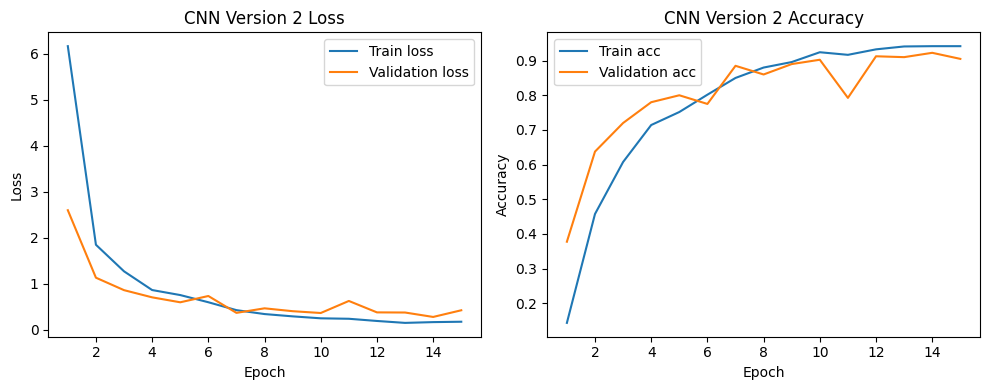

In [68]:
epochs_v2 = range(1, len(train_losses_v2) + 1)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_v2, train_losses_v2, label="Train loss")
plt.plot(epochs_v2, val_losses_v2, label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("CNN Version 2 Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_v2, train_accuracies_v2, label="Train acc")
plt.plot(epochs_v2, val_accuracies_v2, label="Validation acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("CNN Version 2 Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

A similar pattern can be seen in CNN version 2 loss and accuracy plots over epochs as we saw in CNN version 1 where the validation plateaus while training keeps performing better suggesting convergence. 

In [43]:
extra_epochs_v3 = 10

for epoch in range(5, 5 + extra_epochs_v3):
    train_loss, train_acc = train_one_epoch(
        pose_model_v3,
        train_loader,
        pose_optimizer_v3,
        pose_loss_v3,
        device,
    )

    val_loss, val_acc = evaluate(
        pose_model_v3,
        val_loader,
        pose_loss_v3,
        device,
    )

    train_losses_v3.append(train_loss)
    val_losses_v3.append(val_loss)
    train_accuracies_v3.append(train_acc)
    val_accuracies_v3.append(val_acc)

    print(
        f"CNN Version 3 Epoch {epoch+1}: Train loss: {train_loss:.3f}, Train acc: {train_acc:.3f}, Val loss: {val_loss:.3f}, Val acc: {val_acc:.3f}"
    )

CNN Version 3 Epoch 6: Train loss: 0.415, Train acc: 0.872, Val loss: 0.886, Val acc: 0.685
CNN Version 3 Epoch 7: Train loss: 0.353, Train acc: 0.886, Val loss: 0.922, Val acc: 0.730
CNN Version 3 Epoch 8: Train loss: 0.287, Train acc: 0.902, Val loss: 0.824, Val acc: 0.715
CNN Version 3 Epoch 9: Train loss: 0.229, Train acc: 0.922, Val loss: 1.243, Val acc: 0.650
CNN Version 3 Epoch 10: Train loss: 0.189, Train acc: 0.938, Val loss: 0.839, Val acc: 0.730
CNN Version 3 Epoch 11: Train loss: 0.187, Train acc: 0.943, Val loss: 0.569, Val acc: 0.807
CNN Version 3 Epoch 12: Train loss: 0.149, Train acc: 0.955, Val loss: 1.270, Val acc: 0.690
CNN Version 3 Epoch 13: Train loss: 0.159, Train acc: 0.950, Val loss: 0.714, Val acc: 0.795
CNN Version 3 Epoch 14: Train loss: 0.122, Train acc: 0.967, Val loss: 0.974, Val acc: 0.733
CNN Version 3 Epoch 15: Train loss: 0.090, Train acc: 0.975, Val loss: 0.587, Val acc: 0.835


No clear convergence is seen after 15 epochs for version 3 therefore we decide to add 15 more epochs for safe measure. 

In [44]:
extra_epochs_v3_2 = 15

for epoch in range(15, 15 + extra_epochs_v3_2):
    train_loss, train_acc = train_one_epoch(
        pose_model_v3,
        train_loader,
        pose_optimizer_v3,
        pose_loss_v3,
        device,
    )

    val_loss, val_acc = evaluate(
        pose_model_v3,
        val_loader,
        pose_loss_v3,
        device,
    )

    train_losses_v3.append(train_loss)
    val_losses_v3.append(val_loss)
    train_accuracies_v3.append(train_acc)
    val_accuracies_v3.append(val_acc)

    print(
        f"CNN Version 3 Epoch {epoch+1}: Train loss: {train_loss:.3f}, Train acc: {train_acc:.3f}, Val loss: {val_loss:.3f}, Val acc: {val_acc:.3f}"
    )

CNN Version 3 Epoch 16: Train loss: 0.058, Train acc: 0.987, Val loss: 0.384, Val acc: 0.895
CNN Version 3 Epoch 17: Train loss: 0.118, Train acc: 0.962, Val loss: 1.472, Val acc: 0.593
CNN Version 3 Epoch 18: Train loss: 0.086, Train acc: 0.977, Val loss: 0.508, Val acc: 0.845
CNN Version 3 Epoch 19: Train loss: 0.035, Train acc: 0.995, Val loss: 0.424, Val acc: 0.882
CNN Version 3 Epoch 20: Train loss: 0.055, Train acc: 0.983, Val loss: 0.578, Val acc: 0.833
CNN Version 3 Epoch 21: Train loss: 0.107, Train acc: 0.974, Val loss: 0.578, Val acc: 0.843
CNN Version 3 Epoch 22: Train loss: 0.036, Train acc: 0.989, Val loss: 0.377, Val acc: 0.905
CNN Version 3 Epoch 23: Train loss: 0.037, Train acc: 0.992, Val loss: 0.540, Val acc: 0.853
CNN Version 3 Epoch 24: Train loss: 0.031, Train acc: 0.989, Val loss: 0.551, Val acc: 0.873
CNN Version 3 Epoch 25: Train loss: 0.023, Train acc: 0.994, Val loss: 0.398, Val acc: 0.910
CNN Version 3 Epoch 26: Train loss: 0.059, Train acc: 0.984, Val loss:

So for version 3 of the CNN using ResNet18, we achieve a fluctuation validation accuracy of around 85-90% with a peak at epoch 25 having a validation accuracy of 91%. The higher number of epochs required to reach convergence reflects ResNet18's higher complexity and need for more optimisation steps compared to the previus two CNN architectures. 

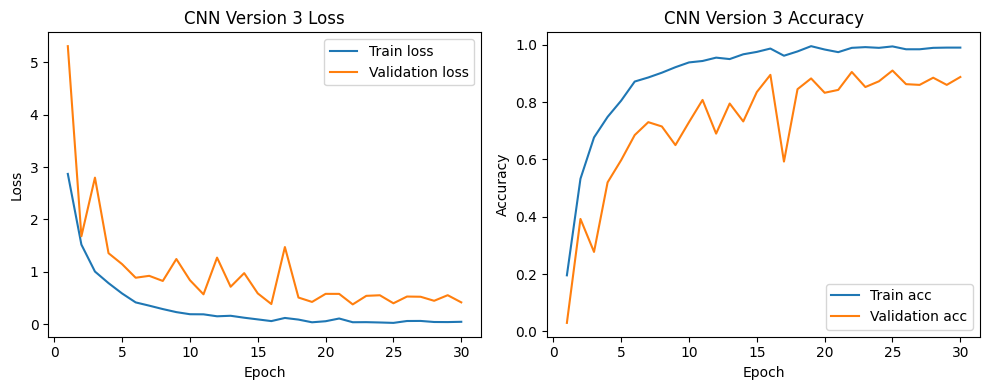

In [69]:
epochs_v3 = range(1, len(train_losses_v3) + 1)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_v3, train_losses_v3, label="Train loss")
plt.plot(epochs_v3, val_losses_v3, label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("CNN Version 3 Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_v3, train_accuracies_v3, label="Train acc")
plt.plot(epochs_v3, val_accuracies_v3, label="Validation acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("CNN Version 3 Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

Using the graphs above, we are able to visualise how loss and accuracy evolve in both training and validation set. Same patterns as CNN version 1 and 2 can be seen in CNN version 3, however CNN version 3 does have more fluctuations from epoch to epoch, suggesting instability. This can be due to the small number of data available in the validation set, where one missclassification has more weight to the accuracy than one missclassification in the training set. Another reason can be because of the complexity of the ResNet18 model which due to the lack of pretrained weights, and small number of data, did not perform as well as the simpler CNN versions 1 and 2. Despite this, towards the last epochs, CNN version 3 or ResNet18 is still able to converge to around 85-90% accuracy.

One point worth noting is that in future project k-fold cross validation can be considered instead of using one fixed validation set. This could provide more reliable estimates of how a model generalises instead of relying on only one single validation set.

In [46]:
def evaluate_classification_metrics(model, data_loader, device, num_classes):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in data_loader:
            if len(batch) == 3:
                images, labels, _ = batch
            else:
                images, labels = batch

            images = images.to(device)
            labels = labels.to(device)

            logits = model(images)
            preds = torch.argmax(logits, dim=1)

            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())

    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()

    acc = accuracy_score(all_labels, all_preds)

    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels,
        all_preds,
        average="macro",
        zero_division=0,
    )
    cm = confusion_matrix(all_labels, all_preds, labels=list(range(num_classes)))
    return acc, precision, recall, f1, cm


We create a function to help compute accuracy, macro precision/recall/F1, and the confusion matrix. 

In [49]:
acc_v1, prec_v1, rec_v1, f1_v1, cm_v1 = evaluate_classification_metrics(
    pose_model_v1,
    val_loader,
    device,
    num_pose_classes,
)

print("CNN Version 1 Validation metrics")
print("Accuracy:", acc_v1)
print("Average Precision per Class:", prec_v1)
print("Average Recall per Class:", rec_v1)
print("Average F1 per Class:", f1_v1)

CNN Version 1 Validation metrics
Accuracy: 0.905
Average Precision per Class: 0.9160318847818848
Average Recall per Class: 0.905
Average F1 per Class: 0.903731668452694


For our CNN version 1 we can see relatively high performance accross all metrics on the validation set, with a accuracy and average recall per class of around 90.5%. The high average precision per class of around 91.6% and also high recall results in the average F1 per class of around 90.4%.

In [57]:
acc_v2, prec_v2, rec_v2, f1_v2, cm_v2 = evaluate_classification_metrics(
    pose_model_v2,
    val_loader,
    device,
    num_pose_classes,
)

print("CNN Version 2 Validation metrics")
print("Accuracy:", acc_v2)
print("Average Precision per Class:", prec_v2)
print("Average Recal per Class:", rec_v2)
print("Average F1 per Class:", f1_v2)

CNN Version 2 Validation metrics
Accuracy: 0.905
Average Precision per Class: 0.9237462863933453
Average Recal per Class: 0.905
Average F1 per Class: 0.9054030851043235


For the CNN version 2, we cann see relativly similar metrics being achieved on the validation set compared to CNN version 1 with slightly better precision of around 92.4% and leading to a slightly better F1 of 90.5%. This suggests how batch normalisation and dropout did not have a extensive effect on the overall performance of the model.

In [58]:
acc_v3, prec_v3, rec_v3, f1_v3, cm_v3 = evaluate_classification_metrics(
    pose_model_v3,
    val_loader,
    device,
    num_pose_classes,
)

print("CNN Version 3 Validation metrics")
print("Accuracy:", acc_v3)
print("Average Precision per Class:", prec_v3)
print("Average Recall per Class:", rec_v3)
print("Average F1 per Class:", f1_v3)

CNN Version 3 Validation metrics
Accuracy: 0.8875
Average Precision per Class: 0.9017052392052392
Average Recall per Class: 0.8875
Average F1 per Class: 0.8859591634864887


On the validation set, CNN version 3 or ResNet18 achieves lower performance accross all metrics compared to CNN version 1 and 2. One reason for this is due to the deeper architecture of ResNet18, which without any pretraining and using the same learning rate, it would require more data to perform better compared to the simpler CNN versions 1 and 2 that could achieve convergence faster in just 15 epochs. One thing to also note before moving on is a limitation where during training, all CNN versions reached a higher peak validation accuracy at an epoch that was not the last epoch, for example version 2 reached a higher peak validation accuracy at epoch 14 but for the final evaluation, the epoch 15 version is used. This highlights a limitation in this project that could be fixed in future projects using early stopping functions to save the weights from the best validation epoch.

In [138]:
acc1_test, prec1_test, rec1_test, f1_1_test, cm1_test = evaluate_classification_metrics(
    pose_model_v1,
    test_loader,
    device,
    num_pose_classes,
)

print("CNN Version 1 test metrics")
print("Accuracy:", acc1_test)
print("Average Precision per Class:", prec1_test)
print("Average Recall per Class:", rec1_test)
print("Average F1 per Class:", f1_1_test)

acc2_test, prec2_test, rec2_test, f1_2_test, cm2_test = evaluate_classification_metrics(
    pose_model_v2,
    test_loader,
    device,
    num_pose_classes,
)

print("CNN Version 2 test metrics")
print("Accuracy:", acc2_test)
print("Average Precision per Class:", prec2_test)
print("Average Recall per Class:", rec2_test)
print("Average F1 per Class:", f1_2_test)

acc3_test, prec3_test, rec3_test, f1_3_test, cm3_test = evaluate_classification_metrics(
    pose_model_v3,
    test_loader,
    device,
    num_pose_classes,
)

print("CNN Version 3 test metrics")
print("Accuracy:", acc3_test)
print("Average Precision per Class:", prec3_test)
print("Average Recall per Class:", rec3_test)
print("Average F1 per Class:", f1_3_test)


CNN Version 1 test metrics
Accuracy: 0.8725
Average Precision per Class: 0.8892395798645799
Average Recall per Class: 0.8724999999999999
Average F1 per Class: 0.869748949749791
CNN Version 2 test metrics
Accuracy: 0.88
Average Precision per Class: 0.8985802392052392
Average Recall per Class: 0.8800000000000001
Average F1 per Class: 0.8798180531348521
CNN Version 3 test metrics
Accuracy: 0.8625
Average Precision per Class: 0.8918685481185481
Average Recall per Class: 0.8625
Average F1 per Class: 0.8593315522178424


On the test set we can see all the CNN versions achieve similar results, however consistent with the validation set results, CNN version 1 and 2 mostly performed better than CNN version 3, with the precision of CNN version 3 being the only metric that is higher than CNN version 1. CNN version 2 displays the highest performance overall, suggesting that the added batch normalisation as well as hidden layer with the dropout value improved the ability of the model to generalise.

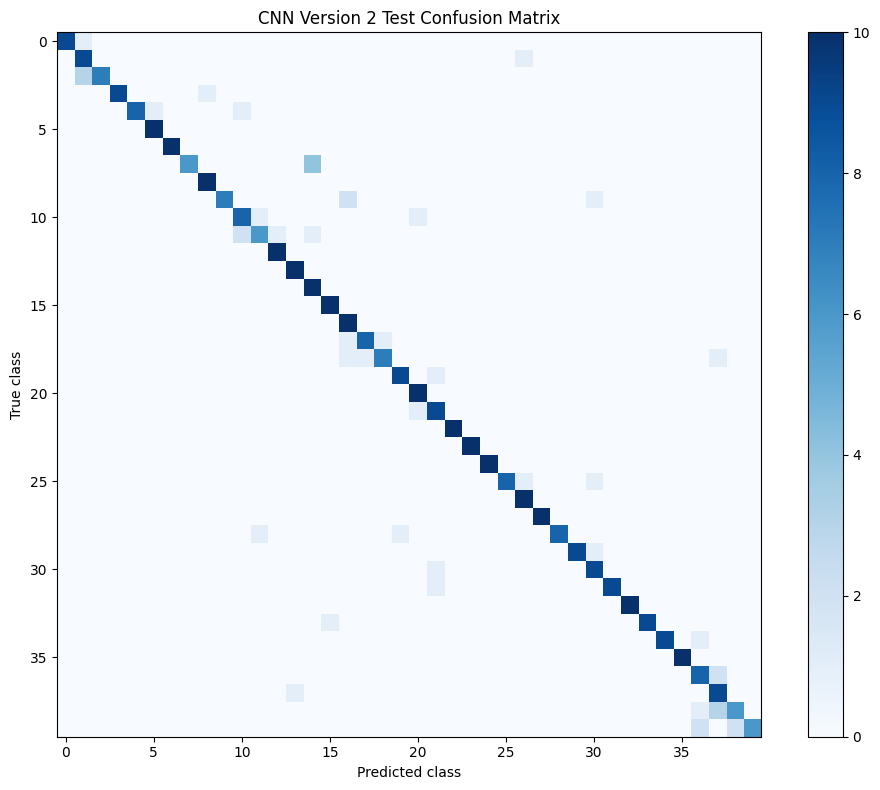

In [63]:
def plot_confusion_matrix(cm, title="Confusion matrix"):
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation="nearest", cmap="Blues")
    plt.title(title)
    plt.colorbar()
    plt.xlabel("Predicted class")
    plt.ylabel("True class")
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(cm2_test, title="CNN Version 2 Test Confusion Matrix")

We decide to plot the confusion matrix of CNN version 2 being the best performing model, and through the matrix, we are able to visualize a very clear diagonal with a few faint off diagonal entries. This reflects the models performance and high accuracy only missclassifying a small percentage of the observations. We can also note that a lot of the off diagonal entries are located near the diagonal suggesting that the model mainly has trouble with similar pitch and roll configurations that are visually challenging to distinguish.

Before moving to the next step, a further limitation to note is that in this project, we formulated pose estimation as a 40 class classification problem, where each class is made of a specific combination of the two features pitch and roll. While doing this did simplify our interpretation of the project, it also might have limited the performance of the models as the way the data set was naturally layed out might have suggested to training pitch and roll seperately. This can also be seen in how in the (Wei & Zhang, 2025) paper, they trained pitch and roll seperately and achieved much higher performance metrics close to 100%. 

## C. Depth Estimation (Regression)

### 1-4. Model Design, Optimization, Regulation, Evaluation and Analysis

In [71]:
train_dataset_depth = MicrorobotDataset(
    train_samples,
    transform=train_transform,
    target_type="depth",
    depth_mean=depth_mean,
    depth_std=depth_std,
    standardize_depth=True,
)

val_dataset_depth = MicrorobotDataset(
    val_samples,
    transform=val_test_transform,
    target_type="depth",
    depth_mean=depth_mean,
    depth_std=depth_std,
    standardize_depth=True,
)

test_dataset_depth = MicrorobotDataset(
    test_samples,
    transform=val_test_transform,
    target_type="depth",
    depth_mean=depth_mean,
    depth_std=depth_std,
    standardize_depth=True,
)

For the depth regression task we decide to create train, validation and test datesets specifically returning standardised depth value and image for a more clear interpretation instead of using the same data loaders we used for the classification task which returned pose class, depth and image. 

In [72]:
batch_size = 32

train_loader_depth = DataLoader(
    train_dataset_depth,
    batch_size=batch_size,
    shuffle=True,
)

val_loader_depth = DataLoader(
    val_dataset_depth,
    batch_size=batch_size,
    shuffle=False,
)

test_loader_depth = DataLoader(
    test_dataset_depth,
    batch_size=batch_size,
    shuffle=False,
)

As mentioned, dataloaders are created for depth regression tasks. 

In [90]:
class DepthCNN_V1(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.conv_block3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.fc = nn.Linear(64 * 32 * 32, 1)

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)

        x = x.view(x.size(0), -1)  
        x = self.fc(x)             
        return x

depth_model_v1 = DepthCNN_V1().to(device)
print(depth_model_v1)


DepthCNN_V1(
  (conv_block1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=65536, out_features=1, bias=True)
)


For depth regression, we decide to reuse the three models we used for pose classification starting with CNN version 1 which has the same three block structure of convolution, ReLU, and max pool. However, instead of the classifier output at the end with 40 logits as output, we have a single output for the standardised depth value of each image. 

In [91]:
depth_loss_fn = nn.MSELoss()
depth_optimizer_v1 = optim.Adam(depth_model_v1.parameters(), lr=1e-3)

Here we define standard MSE loss function using again Adam as the optimizer.

In [92]:
def train_one_epoch_depth(model, loader, optimizer, loss_fn, device):
    model.train()
    running_loss = 0.0
    running_total = 0
    all_targets = []
    all_preds = []

    for images, depths in loader:
        images = images.to(device)
        depths = depths.to(device, dtype=torch.float32)

        optimizer.zero_grad()
        preds = model(images).squeeze(1)
        loss = loss_fn(preds, depths)

        loss.backward()
        optimizer.step()

        batch_size = depths.size(0)
        running_loss += loss.item() * batch_size
        running_total += batch_size

        all_targets.append(depths.detach().cpu().numpy())
        all_preds.append(preds.detach().cpu().numpy())

    epoch_loss = running_loss / running_total
    y_true = np.concatenate(all_targets).ravel()
    y_pred = np.concatenate(all_preds).ravel()
    epoch_r2 = r2_score(y_true, y_pred)

    return epoch_loss, epoch_r2


def evaluate_depth(model, loader, loss_fn, device):
    model.eval()
    running_loss = 0.0
    running_total = 0
    all_targets = []
    all_preds = []

    with torch.no_grad():
        for images, depths in loader:
            images = images.to(device)
            depths = depths.to(device, dtype=torch.float32)

            preds = model(images).squeeze(1)
            loss = loss_fn(preds, depths)

            batch_size = depths.size(0)
            running_loss += loss.item() * batch_size
            running_total += batch_size

            all_targets.append(depths.detach().cpu().numpy())
            all_preds.append(preds.detach().cpu().numpy())

    epoch_loss = running_loss / running_total
    y_true = np.concatenate(all_targets).ravel()
    y_pred = np.concatenate(all_preds).ravel()
    epoch_r2 = r2_score(y_true, y_pred)

    return epoch_loss, epoch_r2

We define two functions, one for training the depth model for one epoch and returning the average training MSE and R squared, and the other to evaluate the depth model on validation or test set also returning average MSE and R squared.


In [93]:
num_epochs_depth_v1 = 5

train_losses_depth_v1 = []
val_losses_depth_v1 = []
train_r2_depth_v1 = []
val_r2_depth_v1 = []

for epoch in range(num_epochs_depth_v1):
    train_loss, train_r2 = train_one_epoch_depth(
        depth_model_v1,
        train_loader_depth,
        depth_optimizer_v1,
        depth_loss_fn,
        device,
    )

    val_loss, val_r2 = evaluate_depth(
        depth_model_v1,
        val_loader_depth,
        depth_loss_fn,
        device,
    )

    train_losses_depth_v1.append(train_loss)
    val_losses_depth_v1.append(val_loss)
    train_r2_depth_v1.append(train_r2)
    val_r2_depth_v1.append(val_r2)

    print(
        f"Depth CNN V1 Epoch {epoch+1}: Train MSE: {train_loss:.3f}, Train R2: {train_r2:.3f}, Val MSE: {val_loss:.3f}, Val R2: {val_r2:.3f}"
    )

Depth CNN V1 Epoch 1: Train MSE: 1.126, Train R2: -0.126, Val MSE: 0.691, Val R2: 0.237
Depth CNN V1 Epoch 2: Train MSE: 0.487, Train R2: 0.513, Val MSE: 0.317, Val R2: 0.650
Depth CNN V1 Epoch 3: Train MSE: 0.259, Train R2: 0.741, Val MSE: 0.188, Val R2: 0.793
Depth CNN V1 Epoch 4: Train MSE: 0.173, Train R2: 0.827, Val MSE: 0.143, Val R2: 0.843
Depth CNN V1 Epoch 5: Train MSE: 0.158, Train R2: 0.842, Val MSE: 0.122, Val R2: 0.866


Like in the pose classification task, we firstly compute 5 epochs for each model to check if MSE decreases and R squared increases which it does in both training and validation.

In [105]:
class DepthCNN_V2(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.conv_block3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.fc1 = nn.Linear(64 * 32 * 32, 256)
        self.dropout = nn.Dropout(p=0.2)
        self.fc2 = nn.Linear(256, 1) 

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)

        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

depth_model_v2 = DepthCNN_V2().to(device)
print(depth_model_v2)

DepthCNN_V2(
  (conv_block1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=65536, out_features=256, bias=True)
  (dropout): Dropout(p=0.2, inpla

Similarly to Pose classification for the second Depth CNN model or Depth CNN version 2, we maintained the same convolution ReLU and max pool structure, but we also added batch normalisation and a hidden layer with ReLU and dropout. 

In [106]:
depth_optimizer_v2 = optim.Adam(depth_model_v2.parameters(), lr=1e-3)
num_epochs_depth_v2 = 5

train_losses_depth_v2 = []
val_losses_depth_v2 = []
train_r2_depth_v2 = []
val_r2_depth_v2 = []

for epoch in range(num_epochs_depth_v2):
    train_loss, train_r2 = train_one_epoch_depth(
        depth_model_v2,
        train_loader_depth,
        depth_optimizer_v2,
        depth_loss_fn,
        device,
    )

    val_loss, val_r2 = evaluate_depth(
        depth_model_v2,
        val_loader_depth,
        depth_loss_fn,
        device,
    )

    train_losses_depth_v2.append(train_loss)
    val_losses_depth_v2.append(val_loss)
    train_r2_depth_v2.append(train_r2)
    val_r2_depth_v2.append(val_r2)

    print(
        f"Depth CNN V2 Epoch {epoch+1}: Train MSE: {train_loss:.3f}, Train R2: {train_r2:.3f}, Val MSE: {val_loss:.3f}, Val R2: {val_r2:.3f}"
    )

Depth CNN V2 Epoch 1: Train MSE: 506.963, Train R2: -505.963, Val MSE: 0.829, Val R2: 0.084
Depth CNN V2 Epoch 2: Train MSE: 2.130, Train R2: -1.130, Val MSE: 0.685, Val R2: 0.244
Depth CNN V2 Epoch 3: Train MSE: 0.761, Train R2: 0.239, Val MSE: 0.389, Val R2: 0.570
Depth CNN V2 Epoch 4: Train MSE: 0.492, Train R2: 0.508, Val MSE: 0.289, Val R2: 0.681
Depth CNN V2 Epoch 5: Train MSE: 0.409, Train R2: 0.591, Val MSE: 0.243, Val R2: 0.732


The model seems to be working for depth CNN version 2 as well, with MSE decreasing and R squared increasing, but both metrics on both training and validation seem to be learning at a slower rate.

In [87]:
class DepthCNN_V3(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()

        self.backbone = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1 if pretrained else None)
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(in_features, 1)

    def forward(self, x):
        x = self.backbone(x)
        return x


depth_model_v3 = DepthCNN_V3(pretrained=True).to(device)
print(depth_model_v3)

DepthCNN_V3(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

For our Depth CNN version 3, like in pose classification we use ResNet18. However, differently from task 2, we decided not to train ResNet18 from scratch, as it performed poorly compared to the other 2 more simple CNN models, likely due to lack of dataset and model complexity. Therefore, we use pretrained weights to obvserve whether we are able to output better performance metrics.

In [88]:
depth_optimizer_v3 = optim.Adam(depth_model_v3.parameters(), lr=1e-3)

num_epochs_depth_v3 = 5

train_losses_depth_v3 = []
val_losses_depth_v3 = []
train_r2_depth_v3 = []
val_r2_depth_v3 = []

for epoch in range(num_epochs_depth_v3):
    train_loss, train_r2 = train_one_epoch_depth(
        depth_model_v3,
        train_loader_depth,
        depth_optimizer_v3,
        depth_loss_fn,
        device,
    )

    val_loss, val_r2 = evaluate_depth(
        depth_model_v3,
        val_loader_depth,
        depth_loss_fn,
        device,
    )

    train_losses_depth_v3.append(train_loss)
    val_losses_depth_v3.append(val_loss)
    train_r2_depth_v3.append(train_r2)
    val_r2_depth_v3.append(val_r2)

    print(
        f"Depth CNN V3 Epoch {epoch+1}: Train MSE: {train_loss:.3f}, Train R2: {train_r2:.3f}, Val MSE: {val_loss:.3f}, Val R2: {val_r2:.3f}"
    )


Depth CNN V3 Epoch 1: Train MSE: 0.799, Train R2: 0.201, Val MSE: 0.133, Val R2: 0.853
Depth CNN V3 Epoch 2: Train MSE: 0.178, Train R2: 0.822, Val MSE: 0.041, Val R2: 0.955
Depth CNN V3 Epoch 3: Train MSE: 0.068, Train R2: 0.932, Val MSE: 0.082, Val R2: 0.910
Depth CNN V3 Epoch 4: Train MSE: 0.072, Train R2: 0.928, Val MSE: 0.060, Val R2: 0.934
Depth CNN V3 Epoch 5: Train MSE: 0.062, Train R2: 0.938, Val MSE: 0.047, Val R2: 0.949


Depth CNN version 3 uses ResNet18 with ImageNet pretrained weight behaves very differenly from no pretrained weights ResNet18 from pose classification, being able to achieve high R squared and low MSE almost immedietly fluctuating between 0.85-0.95 R squared in the validation set in the first five epochs. Compared to simpler depth CNNs version 1 and 2, version 3 achieves lower error and higher R-squared much faster, supporting the choice of pretrained weights in ResNet18.

Although the performance of ResNet18 improved significantly with ImageNet pretraining, a limitation to consider is that this superior performance compared to previous versions 1 and 2 is due not only to the added complexity in the architecture of ResNet18 but also to the extra information from the pretraining that is not available to the simpler CNN models.

In [94]:
extra_epochs_v1 = 10
start_epoch_v1 = len(train_losses_depth_v1)
end_epoch_v1 = start_epoch_v1 + extra_epochs_v1

for epoch in range(start_epoch_v1, end_epoch_v1):
    train_loss, train_r2 = train_one_epoch_depth(
        depth_model_v1,
        train_loader_depth,
        depth_optimizer_v1,
        depth_loss_fn,
        device,
    )

    val_loss, val_r2 = evaluate_depth(
        depth_model_v1,
        val_loader_depth,
        depth_loss_fn,
        device,
    )

    train_losses_depth_v1.append(train_loss)
    val_losses_depth_v1.append(val_loss)
    train_r2_depth_v1.append(train_r2)
    val_r2_depth_v1.append(val_r2)

    print(
        f"Depth CNN V1 Epoch {epoch+1}: Train MSE: {train_loss:.3f}, Train R2: {train_r2:.3f}, Val MSE: {val_loss:.3f}, Val R2: {val_r2:.3f}"
    )

Depth CNN V1 Epoch 6: Train MSE: 0.117, Train R2: 0.883, Val MSE: 0.128, Val R2: 0.859
Depth CNN V1 Epoch 7: Train MSE: 0.118, Train R2: 0.882, Val MSE: 0.093, Val R2: 0.897
Depth CNN V1 Epoch 8: Train MSE: 0.094, Train R2: 0.906, Val MSE: 0.113, Val R2: 0.876
Depth CNN V1 Epoch 9: Train MSE: 0.109, Train R2: 0.891, Val MSE: 0.106, Val R2: 0.883
Depth CNN V1 Epoch 10: Train MSE: 0.090, Train R2: 0.910, Val MSE: 0.085, Val R2: 0.906
Depth CNN V1 Epoch 11: Train MSE: 0.075, Train R2: 0.925, Val MSE: 0.069, Val R2: 0.924
Depth CNN V1 Epoch 12: Train MSE: 0.070, Train R2: 0.930, Val MSE: 0.067, Val R2: 0.926
Depth CNN V1 Epoch 13: Train MSE: 0.066, Train R2: 0.934, Val MSE: 0.066, Val R2: 0.927
Depth CNN V1 Epoch 14: Train MSE: 0.063, Train R2: 0.937, Val MSE: 0.062, Val R2: 0.931
Depth CNN V1 Epoch 15: Train MSE: 0.055, Train R2: 0.945, Val MSE: 0.057, Val R2: 0.937


We add another 10 extra epochs to the orginal 5 in our Depth CNN version 1 and see the results are stedily performing better, although with diminishing returns after each epoch, we believe it has still not reached its plateu or best performing model, and therefore decide to keep adding more epochs. 

In [96]:
def continue_depth_with_early_stopping(
    model,
    train_loader,
    val_loader,
    optimizer,
    loss_fn,
    device,
    train_losses,
    val_losses,
    train_r2s,
    val_r2s,
    max_extra_epochs=50,
    cap=5,
):
    if len(val_losses) > 0:
        best_val_loss = min(val_losses)
        best_epoch = int(np.argmin(val_losses))
        best_val_r2 = val_r2s[best_epoch]
    else:
        best_val_loss = float("inf")
        best_epoch = -1
        best_val_r2 = None

    best_state = model.state_dict()
    epochs_no_improve = 0

    start_epoch = len(train_losses)
    end_epoch = start_epoch + max_extra_epochs

    for epoch in range(start_epoch, end_epoch):
        train_loss, train_r2 = train_one_epoch_depth(
            model,
            train_loader,
            optimizer,
            loss_fn,
            device,
        )

        val_loss, val_r2 = evaluate_depth(
            model,
            val_loader,
            loss_fn,
            device,
        )

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_r2s.append(train_r2)
        val_r2s.append(val_r2)

        print(
            f"Epoch {epoch+1}: Train MSE: {train_loss:.3f}, Train R2: {train_r2:.3f}, Val MSE: {val_loss:.3f}, Val R2: {val_r2:.3f}"
        )

        if val_loss < best_val_loss - 1e-4:
            best_val_loss = val_loss
            best_epoch = epoch
            best_val_r2 = val_r2
            best_state = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= cap:
            print(f"Early stopping triggered at epoch {epoch+1}.")
            break

    model.load_state_dict(best_state)
    return best_epoch, best_val_loss, best_val_r2

Recalling one of our limitations from pose classification, we define an early stopping function that returns the best epoch by MSE. Training is allowed to continue for 50 epochs, and early stopping is triggered when the function has not produced a lower MSE than the lowest MSE for more than 5 consecutive epochs.

In [97]:
best_epoch_v1, best_val_loss_v1, best_val_r2_v1 = continue_depth_with_early_stopping(
    depth_model_v1,
    train_loader_depth,
    val_loader_depth,
    depth_optimizer_v1,
    depth_loss_fn,
    device,
    train_losses_depth_v1,
    val_losses_depth_v1,
    train_r2_depth_v1,
    val_r2_depth_v1,
    max_extra_epochs=50,
    cap=5,
)

Epoch 16: Train MSE: 0.054, Train R2: 0.946, Val MSE: 0.051, Val R2: 0.944
Epoch 17: Train MSE: 0.050, Train R2: 0.950, Val MSE: 0.062, Val R2: 0.932
Epoch 18: Train MSE: 0.057, Train R2: 0.943, Val MSE: 0.056, Val R2: 0.938
Epoch 19: Train MSE: 0.054, Train R2: 0.946, Val MSE: 0.048, Val R2: 0.947
Epoch 20: Train MSE: 0.044, Train R2: 0.956, Val MSE: 0.049, Val R2: 0.945
Epoch 21: Train MSE: 0.044, Train R2: 0.956, Val MSE: 0.045, Val R2: 0.950
Epoch 22: Train MSE: 0.043, Train R2: 0.957, Val MSE: 0.044, Val R2: 0.952
Epoch 23: Train MSE: 0.041, Train R2: 0.959, Val MSE: 0.048, Val R2: 0.948
Epoch 24: Train MSE: 0.036, Train R2: 0.964, Val MSE: 0.039, Val R2: 0.957
Epoch 25: Train MSE: 0.032, Train R2: 0.968, Val MSE: 0.047, Val R2: 0.949
Epoch 26: Train MSE: 0.036, Train R2: 0.964, Val MSE: 0.056, Val R2: 0.938
Epoch 27: Train MSE: 0.035, Train R2: 0.965, Val MSE: 0.041, Val R2: 0.954
Epoch 28: Train MSE: 0.032, Train R2: 0.968, Val MSE: 0.037, Val R2: 0.959
Epoch 29: Train MSE: 0.03

From this first run we can see that the model has reached a plateu not only from the similar values towards the last 5-10 epochs, but also from the early stopping function telling us that MSE has not performed better for more than 5 consecutive epochs.

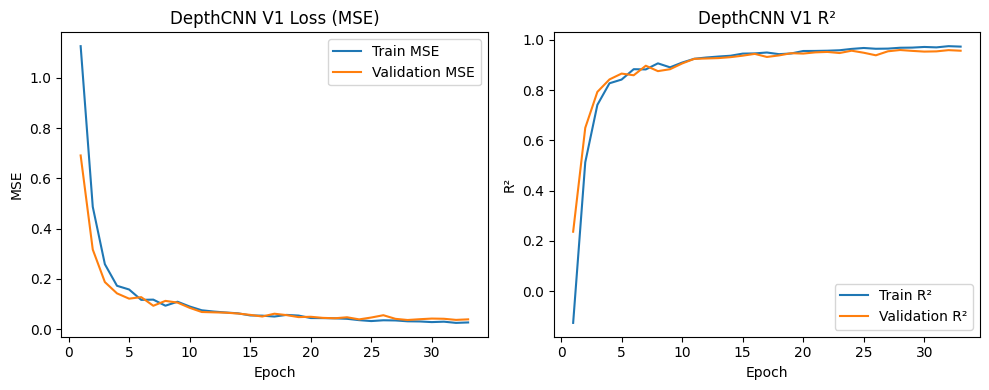

In [100]:
epochs_v1 = range(1, len(train_losses_depth_v1) + 1)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_v1, train_losses_depth_v1, label="Train MSE")
plt.plot(epochs_v1, val_losses_depth_v1, label="Validation MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("DepthCNN V1 Loss (MSE)")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_v1, train_r2_depth_v1, label="Train R²")
plt.plot(epochs_v1, val_r2_depth_v1, label="Validation R²")
plt.xlabel("Epoch")
plt.ylabel("R²")
plt.title("DepthCNN V1 R²")
plt.legend()

plt.tight_layout()
plt.show()

Through these loss and R squared over epoch graphs we are able to better visualize the depth CNN version 1 reaching its plateu performance, having diminishing returns for both performance metrics.

In [107]:
best_epoch_v2, best_val_loss_v2, best_val_r2_v2 = continue_depth_with_early_stopping(
    depth_model_v2,
    train_loader_depth,
    val_loader_depth,
    depth_optimizer_v2,
    depth_loss_fn,
    device,
    train_losses_depth_v2,
    val_losses_depth_v2,
    train_r2_depth_v2,
    val_r2_depth_v2,
    max_extra_epochs=50,
    cap=5,
)

Epoch 6: Train MSE: 0.382, Train R2: 0.618, Val MSE: 0.277, Val R2: 0.694
Epoch 7: Train MSE: 0.356, Train R2: 0.644, Val MSE: 0.240, Val R2: 0.735
Epoch 8: Train MSE: 0.315, Train R2: 0.685, Val MSE: 0.198, Val R2: 0.781
Epoch 9: Train MSE: 0.292, Train R2: 0.708, Val MSE: 0.217, Val R2: 0.761
Epoch 10: Train MSE: 0.278, Train R2: 0.722, Val MSE: 0.173, Val R2: 0.809
Epoch 11: Train MSE: 0.256, Train R2: 0.744, Val MSE: 0.183, Val R2: 0.798
Epoch 12: Train MSE: 0.237, Train R2: 0.763, Val MSE: 0.177, Val R2: 0.805
Epoch 13: Train MSE: 0.232, Train R2: 0.768, Val MSE: 0.164, Val R2: 0.819
Epoch 14: Train MSE: 0.238, Train R2: 0.762, Val MSE: 0.223, Val R2: 0.754
Epoch 15: Train MSE: 0.230, Train R2: 0.770, Val MSE: 0.172, Val R2: 0.810
Epoch 16: Train MSE: 0.221, Train R2: 0.779, Val MSE: 0.148, Val R2: 0.836
Epoch 17: Train MSE: 0.189, Train R2: 0.811, Val MSE: 0.131, Val R2: 0.855
Epoch 18: Train MSE: 0.167, Train R2: 0.833, Val MSE: 0.129, Val R2: 0.857
Epoch 19: Train MSE: 0.180, T

Depth CNN version 2 in this case took a lot more epochs before early stopping is triggered, with MSE steadily decreasing and R squared increasing for both train and validation set. It is interesting to see that validation performed better than train in almost all epochs indicating successful regularisation from dropout and batch normalisation, preventing overfitting.

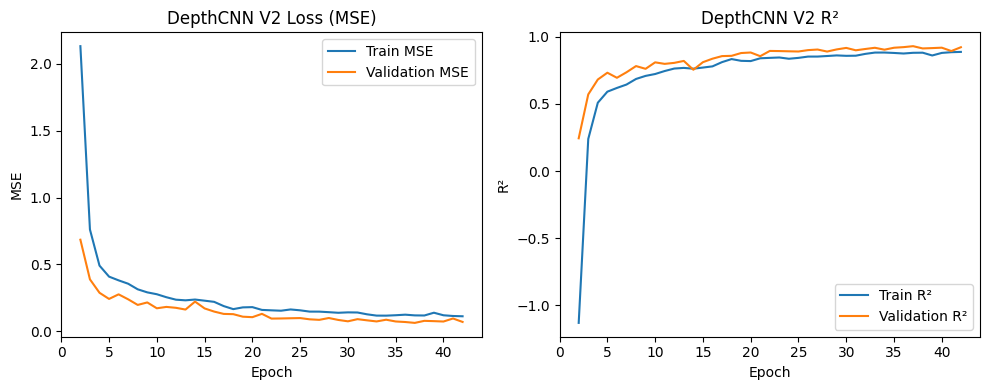

In [110]:
start_idx = 1 

epochs_v2 = range(start_idx + 1, len(train_losses_depth_v2) + 1)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_v2, train_losses_depth_v2[start_idx:], label="Train MSE")
plt.plot(epochs_v2, val_losses_depth_v2[start_idx:], label="Validation MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("DepthCNN V2 Loss (MSE)")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_v2, train_r2_depth_v2[start_idx:], label="Train R²")
plt.plot(epochs_v2, val_r2_depth_v2[start_idx:], label="Validation R²")
plt.xlabel("Epoch")
plt.ylabel("R²")
plt.title("DepthCNN V2 R²")
plt.legend()

plt.tight_layout()
plt.show()

For better visualisation of depth CNN version 2 with skip the first epoch as it was such a very far outlier that messed up the graph. From the graph we can see a standard plauteu like in version 1, and its also confirms our earlier observation where validation set seems to be almost constantly outperforming train set. Even though CNN version 2 for depth was designed as a improved model of version 1 by adding batch normalisation and droupout, it seemed to have performed worst than version 1. This suggests that on a relatively small dataset, as mentioned earlier, extra regularisations and architectural complexity in the model can lead to underfitting.

In [102]:

best_epoch_v3, best_val_loss_v3, best_val_r2_v3 = continue_depth_with_early_stopping(
    depth_model_v3,
    train_loader_depth,
    val_loader_depth,
    depth_optimizer_v3,
    depth_loss_fn,
    device,
    train_losses_depth_v3,
    val_losses_depth_v3,
    train_r2_depth_v3,
    val_r2_depth_v3,
    max_extra_epochs=50,
    cap=5,
)

Epoch 6: Train MSE: 0.056, Train R2: 0.944, Val MSE: 0.031, Val R2: 0.966
Epoch 7: Train MSE: 0.062, Train R2: 0.938, Val MSE: 0.049, Val R2: 0.945
Epoch 8: Train MSE: 0.055, Train R2: 0.945, Val MSE: 0.113, Val R2: 0.875
Epoch 9: Train MSE: 0.074, Train R2: 0.926, Val MSE: 0.071, Val R2: 0.921
Epoch 10: Train MSE: 0.034, Train R2: 0.966, Val MSE: 0.038, Val R2: 0.958
Epoch 11: Train MSE: 0.043, Train R2: 0.957, Val MSE: 0.020, Val R2: 0.978
Epoch 12: Train MSE: 0.045, Train R2: 0.955, Val MSE: 0.064, Val R2: 0.929
Epoch 13: Train MSE: 0.030, Train R2: 0.970, Val MSE: 0.046, Val R2: 0.949
Epoch 14: Train MSE: 0.024, Train R2: 0.976, Val MSE: 0.025, Val R2: 0.972
Epoch 15: Train MSE: 0.023, Train R2: 0.977, Val MSE: 0.023, Val R2: 0.974
Epoch 16: Train MSE: 0.029, Train R2: 0.971, Val MSE: 0.017, Val R2: 0.981
Epoch 17: Train MSE: 0.031, Train R2: 0.969, Val MSE: 0.016, Val R2: 0.982
Epoch 18: Train MSE: 0.036, Train R2: 0.964, Val MSE: 0.120, Val R2: 0.868
Epoch 19: Train MSE: 0.023, T

With the shortest number of epochs before early stopping, Depth CNN version 3 using pretrained ResNet18, seems to have the best performance. As mentioned before, the choice to use pretrained weights is supported by ResNet's capacity to outperform pervious versions 1 and 2. 

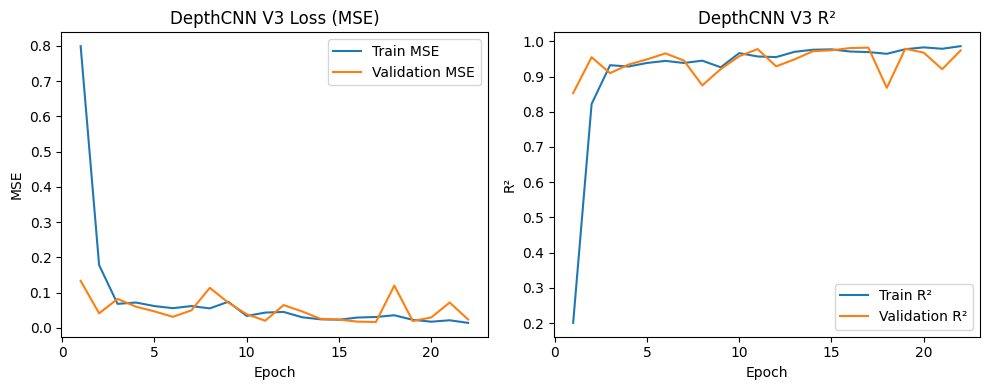

In [109]:
epochs_v3 = range(1, len(train_losses_depth_v3) + 1)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_v3, train_losses_depth_v3, label="Train MSE")
plt.plot(epochs_v3, val_losses_depth_v3, label="Validation MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("DepthCNN V3 Loss (MSE)")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_v3, train_r2_depth_v3, label="Train R²")
plt.plot(epochs_v3, val_r2_depth_v3, label="Validation R²")
plt.xlabel("Epoch")
plt.ylabel("R²")
plt.title("DepthCNN V3 R²")
plt.legend()

plt.tight_layout()
plt.show()

The visualisation clearly shows fluctuations around the same range for the validation set of depth CNN version 3, indicating a convergence is being reached. So from the validation set after observing all models, Depth CNN version 3 performs the best, we will keep that in mind going into test evaluation.

In [137]:
test_loss_v1, test_r2_v1 = evaluate_depth(
    depth_model_v1,
    test_loader_depth,
    depth_loss_fn,
    device,
)

test_loss_v2, test_r2_v2 = evaluate_depth(
    depth_model_v2,
    test_loader_depth,
    depth_loss_fn,
    device,
)

test_loss_v3, test_r2_v3 = evaluate_depth(
    depth_model_v3,
    test_loader_depth,
    depth_loss_fn,
    device,
)

test_rmse_v1 = math.sqrt(test_loss_v1)
test_rmse_v2 = math.sqrt(test_loss_v2)
test_rmse_v3 = math.sqrt(test_loss_v3)

print(
    f"DepthCNN V1 Test MSE: {test_loss_v1:.3f}, Test RMSE: {test_rmse_v1:.3f}, Test R2: {test_r2_v1:.3f}"
)
print(
    f"DepthCNN V2 Test MSE: {test_loss_v2:.3f}, Test RMSE: {test_rmse_v2:.3f}, Test R2: {test_r2_v2:.3f}"
)
print(
    f"DepthCNN V3 Test MSE: {test_loss_v3:.3f}, Test RMSE: {test_rmse_v3:.3f}, Test R2: {test_r2_v3:.3f}"
)

DepthCNN V1 Test MSE: 0.050, Test RMSE: 0.223, Test R2: 0.954
DepthCNN V2 Test MSE: 0.094, Test RMSE: 0.306, Test R2: 0.913
DepthCNN V3 Test MSE: 0.028, Test RMSE: 0.169, Test R2: 0.974


For each depth CNN version, we used the model at the epoch with the best MSE on validation set because of how we defined our early stopping function. In the evaluation, the depth CNN version 3 (ResNet18 pretrained) performed the best with the lowest RMSE at 0.169 and R squared of 0.974. This means that it had the lowest error and was able to explain the most variance in depth regression. Depth CNN version 1 or our baseline model also outputed high performance with a RMSE of 0.223 and R squared of 0.954, but the errors almost double the version 3 model. In contrast, the weakest performing model was depth CNN version 2, which although designed for better performance than depth CNN version 1, with the extra regularisation to reduce overfitting it might have resulted in slight underfitting, producing higher errors.

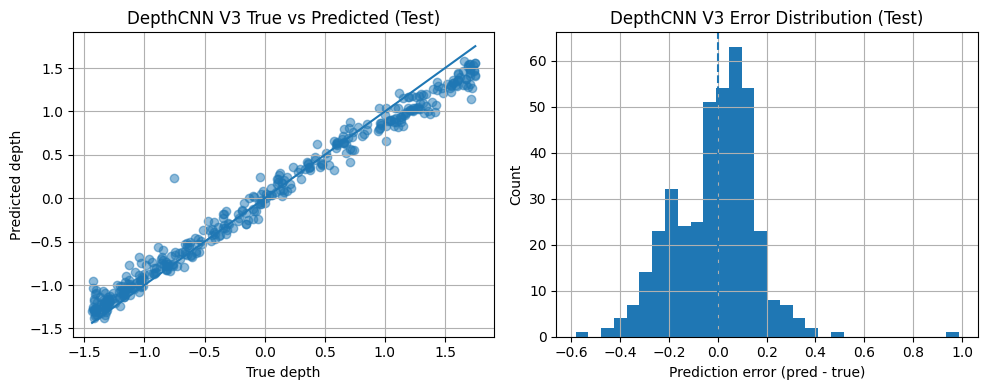

In [119]:
def collect_depth_errors(model, loader, device):
    model.eval()
    all_images = []
    all_true = []
    all_pred = []

    with torch.no_grad():
        for images, depths in loader:
            images = images.to(device)
            depths = depths.float().to(device)
            preds = model(images).squeeze(1)
            all_images.append(images.cpu())
            all_true.append(depths.cpu())
            all_pred.append(preds.cpu())

    images = torch.cat(all_images, dim=0)
    y_true = torch.cat(all_true, dim=0).numpy()
    y_pred = torch.cat(all_pred, dim=0).numpy()
    errors = y_pred - y_true
    return images, y_true, y_pred, errors

images_test_v3, y_true_test_v3, y_pred_test_v3, errors_test_v3 = collect_depth_errors(
    depth_model_v3,
    test_loader_depth,
    device,
)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.scatter(y_true_test_v3, y_pred_test_v3, alpha=0.5)
min_val = min(y_true_test_v3.min(), y_pred_test_v3.min())
max_val = max(y_true_test_v3.max(), y_pred_test_v3.max())
plt.plot([min_val, max_val], [min_val, max_val])  
plt.xlabel("True depth")
plt.ylabel("Predicted depth")
plt.title("DepthCNN V3 True vs Predicted (Test)")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(errors_test_v3, bins=30)
plt.axvline(0.0, linestyle="--")
plt.xlabel("Prediction error (pred - true)")
plt.ylabel("Count")
plt.title("DepthCNN V3 Error Distribution (Test)")
plt.grid(True)

plt.tight_layout()
plt.show()


An error analysis is computed as seen in Figure \ref{fig:erroranalysis.png} for DV3. We observe a true versus predicted depth value graph and a histogram of the error distribution. Both graphs indicate high performance with the true vs predicted graph suggesting that most mistakes occur towards cases with high depth. In the histogram where error is calculated by the difference of the predicted value to the true value, we can observe a bell shaped graph with concentrated values around 0. We can observe edge cases better and discuss them by observing there images.

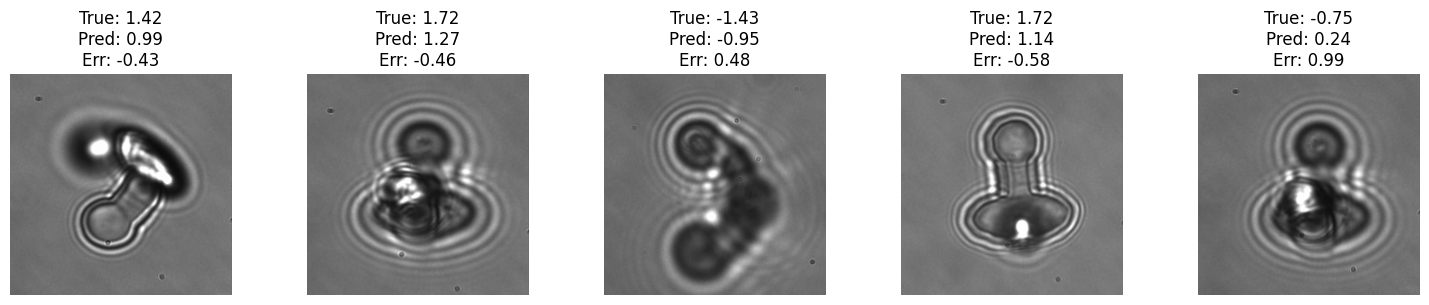

In [120]:
k = 5  

worst_idx = np.argsort(np.abs(errors_test_v3))[-k:]
fig, axes = plt.subplots(1, k, figsize=(3 * k, 3))

for ax, idx in zip(axes, worst_idx):
    img = images_test_v3[idx]
    img_np = img.numpy().transpose(1, 2, 0)
    if img_np.shape[2] == 1:
        img_np = img_np.squeeze(2)

    ax.imshow(img_np, cmap="gray")
    ax.axis("off")
    ax.set_title(
        f"True: {y_true_test_v3[idx]:.2f}\n"
        f"Pred: {y_pred_test_v3[idx]:.2f}\n"
        f"Err: {errors_test_v3[idx]:.2f}"
    )

plt.tight_layout()
plt.show()

3 of the 5 highest edge cases have very similar poses, which indicate that the pose itself is hard to determine the true depth value, with two of the 3 observation having the same true depth which might suggest that at that deph value the modelis not able to properly analyze the image or recognize that pattern. To understand and gain more insight on edge cases we can also observe the distribution of depth values in training set to see whether any depths did not have many samples and resulted in edge cases.

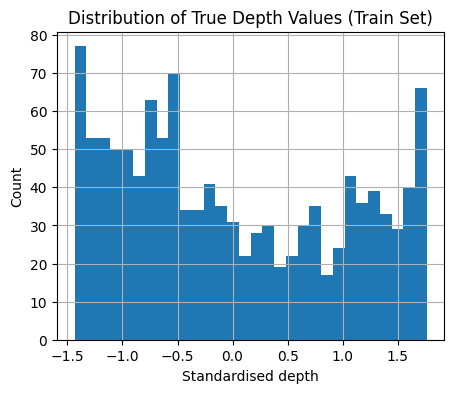

In [142]:
all_train_depths_error_analysis = []

for images, depths in train_loader_depth:
    depths = depths.float()           
    all_train_depths_error_analysis.append(depths.numpy())

train_depths = np.concatenate(all_train_depths_error_analysis).ravel()

plt.figure(figsize=(5, 4))
plt.hist(train_depths, bins=30)
plt.xlabel("Standardised depth")
plt.ylabel("Count")
plt.title("Distribution of True Depth Values (Train Set)")
plt.grid(True)
plt.show()

Viewing the distribution we note that a lot of the edge cases have a lot of samples at their true standardised depth value. We can dig deeper and look into depth distribution for each pose as the edge cases seem to have a similar pose.

Pose 32, True depth = 1.416, Predicted = 0.989, Error = -0.427
Pose 26, True depth = 1.723, Predicted = 1.265, Error = -0.458
Pose 33, True depth = -1.429, Predicted = -0.954, Error = 0.475
Pose 17, True depth = 1.720, Predicted = 1.138, Error = -0.582
Pose 25, True depth = -0.751, Predicted = 0.236, Error = 0.987


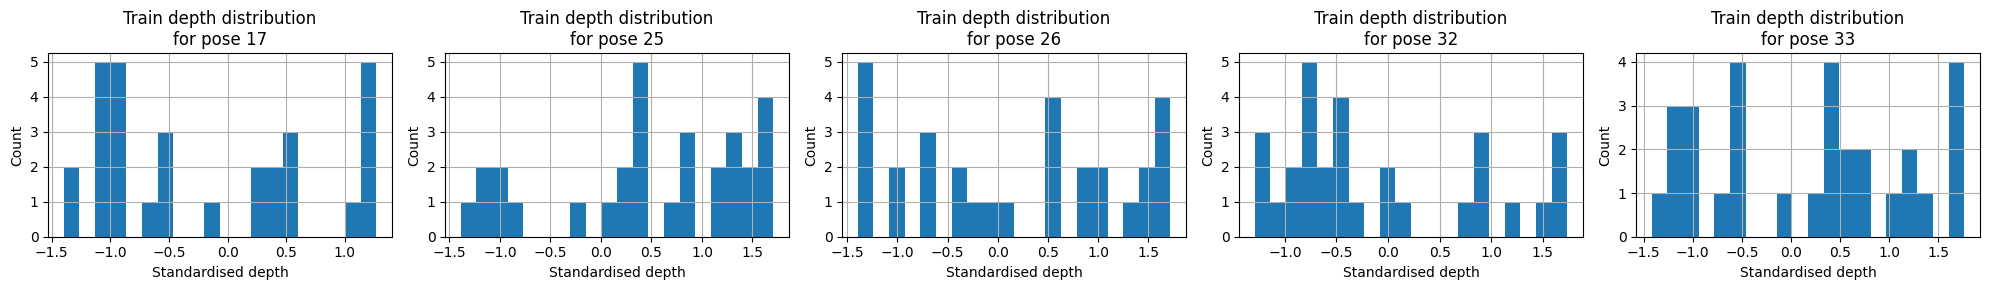

In [149]:
pose_depths_train = {c: [] for c in range(num_pose_classes)}

for images, pose_labels, depths in train_loader:
    depths = depths.float().cpu().numpy().ravel()
    pose_labels = pose_labels.cpu().numpy().ravel()

    for p, d in zip(pose_labels, depths):
        pose_depths_train[int(p)].append(float(d))
def collect_depth_errors_with_pose(model, loader, device):
    model.eval()
    all_images = []
    all_true = []
    all_pred = []
    all_poses = []

    with torch.no_grad():
        for images, pose_labels, depths in loader:
            images = images.to(device)
            depths = depths.float().to(device) 

            preds = model(images).squeeze(1)

            all_images.append(images.cpu())
            all_true.append(depths.cpu())
            all_pred.append(preds.cpu())
            all_poses.append(pose_labels.cpu())

    images = torch.cat(all_images, dim=0)
    y_true = torch.cat(all_true, dim=0).numpy()
    y_pred = torch.cat(all_pred, dim=0).numpy()
    poses  = torch.cat(all_poses, dim=0).numpy()
    errors = y_pred - y_true
    return images, y_true, y_pred, errors, poses

images_test_v3, y_true_test_v3, y_pred_test_v3, errors_test_v3, poses_test_v3 = (
    collect_depth_errors_with_pose(
        depth_model_v3,   
        test_loader,     
        device,
    )
)

k = 5
worst_idx = np.argsort(np.abs(errors_test_v3))[-k:]

edge_poses = poses_test_v3[worst_idx]
unique_edge_poses = sorted(set(int(p) for p in edge_poses))
for idx in worst_idx:
    pose_id = int(poses_test_v3[idx])
    true_d = float(y_true_test_v3[idx])
    pred_d = float(y_pred_test_v3[idx])
    err   = float(errors_test_v3[idx])
    print(
        f"Pose {pose_id:2d}, True depth = {true_d:.3f}, Predicted = {pred_d:.3f}, Error = {err:.3f}"
    )
    n_pos = len(unique_edge_poses)
plt.figure(figsize=(4 * n_pos, 3))

for i, pose_id in enumerate(unique_edge_poses, start=1):
    plt.subplot(1, n_pos, i)
    depths_for_pose = pose_depths_train[pose_id]
    plt.hist(depths_for_pose, bins=20)
    plt.xlabel("Standardised depth")
    plt.ylabel("Count")
    plt.title(f"Train depth distribution\nfor pose {pose_id}")
    plt.grid(True)

plt.tight_layout()
plt.show()

From the the sample distribution observed above, we can make some inference on why the edge cases occurred. In multiple of the edge cases the true depth value for that specific pose had no training observations close to that value visualized by the gaps in those distributions. For example, we take a look at the train depth distribution for pose where the true value is 1.720, but as seen in the histogram for pose 17 the standardised depth doesn't reach a value over 1.5. Instead, looking at the predicted value, 1.138, the number of observations for that value or close to that value is very high. A similar observation can be made for all other edge cases except for pose 26. 

In [121]:

os.makedirs("saved_models", exist_ok=True)

torch.save(depth_model_v1.state_dict(), "saved_models/depth_cnn_v1_best.pth")
torch.save(depth_model_v2.state_dict(), "saved_models/depth_cnn_v2_best.pth")
torch.save(depth_model_v3.state_dict(), "saved_models/depth_cnn_v3_best.pth")
torch.save(pose_model_v1.state_dict(), "saved_models/pose_cnn_v1_best.pth")
torch.save(pose_model_v2.state_dict(), "saved_models/pose_cnn_v2_best.pth")
torch.save(pose_model_v3.state_dict(), "saved_models/pose_cnn_v3_best.pth")

Now that we have all the final models we save them into folder saved_models.

## D. Hyperparameter Tuning

In [124]:
def train_depth_v3_with_params(
    lr,
    weight_decay,
    max_extra_epochs=30,
    cap=5,
):
    model = DepthCNN_V3(pretrained=True).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    train_losses = []
    val_losses = []
    train_r2s = []
    val_r2s = []

    best_epoch, best_val_mse, best_val_r2 = continue_depth_with_early_stopping(
        model,
        train_loader_depth,
        val_loader_depth,
        optimizer,
        depth_loss_fn,
        device,
        train_losses,
        val_losses,
        train_r2s,
        val_r2s,
        max_extra_epochs=max_extra_epochs,
        cap=cap,
    )

    print(
        f"[lr={lr}, wd={weight_decay}], best epoch: {best_epoch+1}, val MSE: {best_val_mse:.3f}, val R²: {best_val_r2:.3f}"
    )

    history = {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_r2s": train_r2s,
        "val_r2s": val_r2s,
        "best_epoch": best_epoch,
        "best_val_mse": best_val_mse,
        "best_val_r2": best_val_r2,
        "lr": lr,
        "weight_decay": weight_decay,
    }

    return model, history


For hyperparameter tuning we use our best model which was the pretrained ResNet18 for depth estimation and the paramaters we tune are the learning rate as well as L2 weight decay to see if they can contribute to a better performance.  

In [123]:
param_grid = [
    {"lr": 1e-3, "weight_decay": 0.0},
    {"lr": 1e-3, "weight_decay": 1e-4},
    {"lr": 1e-4, "weight_decay": 0.0},
    {"lr": 1e-4, "weight_decay": 1e-4},
]

tuned_models_v3 = []
tuning_results_v3 = []

for params in param_grid:
    print("\n Training DepthCNN Version 3 ResNet18 with parameters:", params)
    model, history = train_depth_v3_with_params(lr=params["lr"], weight_decay=params["weight_decay"])
    tuned_models_v3.append(model)
    tuning_results_v3.append(history)

print("\nSummary of validation performance for DepthCNN V3 hyperparameters:")
for h in tuning_results_v3:
    print(
        f"lr={h['lr']}, wd={h['weight_decay']}: best val MSE: {h['best_val_mse']:.3f}, best val R²: {h['best_val_r2']:.3f}, (epoch {h['best_epoch']+1})"
    )


 Training DepthCNN Version 3 ResNet18 with parameters: {'lr': 0.001, 'weight_decay': 0.0}
Epoch 1: Train MSE: 0.798, Train R2: 0.202, Val MSE: 0.112, Val R2: 0.876
Epoch 2: Train MSE: 0.088, Train R2: 0.912, Val MSE: 0.228, Val R2: 0.748
Epoch 3: Train MSE: 0.091, Train R2: 0.909, Val MSE: 0.032, Val R2: 0.964
Epoch 4: Train MSE: 0.065, Train R2: 0.935, Val MSE: 0.056, Val R2: 0.939
Epoch 5: Train MSE: 0.098, Train R2: 0.902, Val MSE: 0.043, Val R2: 0.952
Epoch 6: Train MSE: 0.113, Train R2: 0.887, Val MSE: 0.176, Val R2: 0.806
Epoch 7: Train MSE: 0.079, Train R2: 0.921, Val MSE: 0.122, Val R2: 0.865
Epoch 8: Train MSE: 0.055, Train R2: 0.945, Val MSE: 0.040, Val R2: 0.956
Early stopping triggered at epoch 8.
[lr=0.001, wd=0.0], best epoch: 3, val MSE: 0.032, val R²: 0.964

 Training DepthCNN Version 3 ResNet18 with parameters: {'lr': 0.001, 'weight_decay': 0.0001}
Epoch 1: Train MSE: 1.091, Train R2: -0.091, Val MSE: 0.403, Val R2: 0.555
Epoch 2: Train MSE: 0.129, Train R2: 0.871, Va

From the results above we are able to visualise the best MSE and R squared at each parameter with varying learning rate between 0.001 which was what we used for all the previous models vs 0.0001 which we have not used before as well as adding weight decay for each learning rate and comparing it with no weight decay. The results demonstrate that with a lower learning rate the validation results are substantially better compared to the higher learning rate of 0.001, having around half the error at a MSE of around 0.015. We can see the weight decay has little impact on both learning rate, with the 0.001 learning rate having slightly better performance with weight decay, and 0.0001 learning rate having the same performance with weight decay but requiring less epochs to reach that performance. This minimal effect could be due to the small degree at which weight decay is applied. However, weight decay being able to regularise large weights still allows the model to reach a similar optimal result with fewer epochs. The pretrained ResNet18 performing better with a lower learning rate suggests that with the higher learning rate, the model is not able to properly fine tune the existing features and instead partially over correct and catch unnecessary noise that a smaller learning rate is able to be flexible about. We move on by using the lr = 0.0001 and wd = 0.0001 to evaluate the results on test set as it achieved the best validation results with the highest computational efficiency.

In [129]:
val_mses = [h["best_val_mse"] for h in tuning_results_v3]
min_mse = min(val_mses)
candidate_indices = [i for i, m in enumerate(val_mses) if m == min_mse]
best_idx = min(candidate_indices, key=lambda i: tuning_results_v3[i]["best_epoch"])
best_config = tuning_results_v3[best_idx]
best_model_v3 = tuned_models_v3[best_idx]

print("Best DepthCNN Version 3 from tuning:")
print(
    f"lr = {best_config['lr']}, weight_decay = {best_config['weight_decay']}, best val MSE = {best_config['best_val_mse']:.3f}, best val R² = {best_config['best_val_r2']:.3f}, epoch = {best_config['best_epoch']+1}"
)

test_loss_v3_tuned, test_r2_v3_tuned = evaluate_depth(
    best_model_v3,
    test_loader_depth,
    depth_loss_fn,
    device,
)

test_rmse_v3_tuned = math.sqrt(test_loss_v3_tuned)

print(
    f"Tuned DepthCNN V3 Test MSE: {test_loss_v3_tuned:.3f}, Test RMSE: {test_rmse_v3_tuned:.3f}, Test R²: {test_r2_v3_tuned:.3f}"
)

os.makedirs("saved_models", exist_ok=True)
filename = f"saved_models/depth_cnn_v3_tuned_lr{best_config['lr']}_wd{best_config['weight_decay']}.pth"
torch.save(best_model_v3.state_dict(), filename)

print("Saved tuned DepthCNN V3 to:", filename)

Best DepthCNN Version 3 from tuning:
lr = 0.0001, weight_decay = 0.0001, best val MSE = 0.015, best val R² = 0.984, epoch = 10
Tuned DepthCNN V3 Test MSE: 0.019, Test RMSE: 0.137, Test R²: 0.983
Saved tuned DepthCNN V3 to: saved_models/depth_cnn_v3_tuned_lr0.0001_wd0.0001.pth


Evaluating the results from the test set using the tuned depth CNN version 3 we indeed achieve a better result with RMSE 0.137 compared to the original untuned model.

## Checking Saved Models

In [141]:
depth_v1_test = DepthCNN_V1().to(device)
depth_v1_test.load_state_dict(torch.load("saved_models/depth_cnn_v1_best.pth"))
depth_v1_test.eval()

depth_v2_test = DepthCNN_V2().to(device)
depth_v2_test.load_state_dict(torch.load("saved_models/depth_cnn_v2_best.pth"))
depth_v2_test.eval()

depth_v3_test = DepthCNN_V3(pretrained=False).to(device)
depth_v3_test.load_state_dict(torch.load("saved_models/depth_cnn_v3_best.pth"))
depth_v3_test.eval()

depth_v3_tuned_test = DepthCNN_V3(pretrained=False).to(device)
depth_v3_tuned_test.load_state_dict(
    torch.load("saved_models/depth_cnn_v3_tuned_lr0.0001_wd0.0001.pth")
)
depth_v3_tuned_test.eval()

test_loss_v1_chk, test_r2_v1_chk = evaluate_depth(
    depth_v1_test,
    test_loader_depth,
    depth_loss_fn,
    device,
)
test_rmse_v1_chk = math.sqrt(test_loss_v1_chk)

test_loss_v2_chk, test_r2_v2_chk = evaluate_depth(
    depth_v2_test,
    test_loader_depth,
    depth_loss_fn,
    device,
)
test_rmse_v2_chk = math.sqrt(test_loss_v2_chk)

test_loss_v3_chk, test_r2_v3_chk = evaluate_depth(
    depth_v3_test,
    test_loader_depth,
    depth_loss_fn,
    device,
)
test_rmse_v3_chk = math.sqrt(test_loss_v3_chk)

test_loss_v3_tuned_chk, test_r2_v3_tuned_chk = evaluate_depth(
    depth_v3_tuned_test,
    test_loader_depth,
    depth_loss_fn,
    device,
)
test_rmse_v3_tuned_chk = math.sqrt(test_loss_v3_tuned_chk)

print(f"DepthCNN V1 saved Test MSE: {test_loss_v1_chk:.3f}, RMSE: {test_rmse_v1_chk:.3f}, R2: {test_r2_v1_chk:.3f}")
print(f"DepthCNN V2 saved Test MSE: {test_loss_v2_chk:.3f}, RMSE: {test_rmse_v2_chk:.3f}, R2: {test_r2_v2_chk:.3f}")
print(f"DepthCNN V3 saved Test MSE: {test_loss_v3_chk:.3f}, RMSE: {test_rmse_v3_chk:.3f}, R2: {test_r2_v3_chk:.3f}")
print(f"DepthCNN V3 tuned Test MSE: {test_loss_v3_tuned_chk:.3f}, RMSE: {test_rmse_v3_tuned_chk:.3f}, R2: {test_r2_v3_tuned_chk:.3f}")

DepthCNN V1 saved Test MSE: 0.050, RMSE: 0.223, R2: 0.954
DepthCNN V2 saved Test MSE: 0.094, RMSE: 0.306, R2: 0.913
DepthCNN V3 saved Test MSE: 0.028, RMSE: 0.169, R2: 0.974
DepthCNN V3 tuned Test MSE: 0.019, RMSE: 0.137, R2: 0.983


In [140]:
pose_v1_test = PoseCNN_V1().to(device)
pose_v1_test.load_state_dict(torch.load("saved_models/pose_cnn_v1_best.pth"))
pose_v1_test.eval()

pose_v2_test = PoseCNN_V2().to(device)
pose_v2_test.load_state_dict(torch.load("saved_models/pose_cnn_v2_best.pth"))
pose_v2_test.eval()

pose_v3_test = PoseResNet18(num_classes=num_pose_classes).to(device)
pose_v3_test.load_state_dict(torch.load("saved_models/pose_cnn_v3_best.pth"))
pose_v3_test.eval()

acc1_test_chk, prec1_test_chk, rec1_test_chk, f1_1_test_chk, cm1_test_chk = evaluate_classification_metrics(
    pose_v1_test,
    test_loader,
    device,
    num_pose_classes,
)
print("PoseCNN Version 1 (saved model) test metrics")
print("Accuracy:", acc1_test_chk)
print("Average Precision per Class:", prec1_test_chk)
print("Average Recall per Class:", rec1_test_chk)
print("Average F1 per Class:", f1_1_test_chk)

acc2_test_chk, prec2_test_chk, rec2_test_chk, f1_2_test_chk, cm2_test_chk = evaluate_classification_metrics(
    pose_v2_test,
    test_loader,
    device,
    num_pose_classes,
)
print("\nPoseCNN Version 2 (saved model) test metrics")
print("Accuracy:", acc2_test_chk)
print("Average Precision per Class:", prec2_test_chk)
print("Average Recall per Class:", rec2_test_chk)
print("Average F1 per Class:", f1_2_test_chk)

acc3_test_chk, prec3_test_chk, rec3_test_chk, f1_3_test_chk, cm3_test_chk = evaluate_classification_metrics(
    pose_v3_test,
    test_loader,
    device,
    num_pose_classes,
)
print("\nPoseCNN Version 3 (saved model) test metrics")
print("Accuracy:", acc3_test_chk)
print("Average Precision per Class:", prec3_test_chk)
print("Average Recall per Class:", rec3_test_chk)
print("Average F1 per Class:", f1_3_test_chk)

PoseCNN Version 1 (saved model) test metrics
Accuracy: 0.8725
Average Precision per Class: 0.8892395798645799
Average Recall per Class: 0.8724999999999999
Average F1 per Class: 0.869748949749791

PoseCNN Version 2 (saved model) test metrics
Accuracy: 0.88
Average Precision per Class: 0.8985802392052392
Average Recall per Class: 0.8800000000000001
Average F1 per Class: 0.8798180531348521

PoseCNN Version 3 (saved model) test metrics
Accuracy: 0.8625
Average Precision per Class: 0.8918685481185481
Average Recall per Class: 0.8625
Average F1 per Class: 0.8593315522178424


## References
1. scikit-learn developers, 2025. 11. Common pitfalls and recommended practices. scikit-learn 1.8.0 documentation. Available at: https://scikit-learn.org/stable/common_pitfalls.html (Accessed: 10 December 2025).
2. Wei, L. & Zhang, D., 2025. A dataset and benchmarks for deep learning-based optical microrobot pose and depth perception. arXiv preprint arXiv:2505.18303. Available at: https://arxiv.org/abs/2505.18303 (Accessed: 10 December 2025).